# Implied Volatilty and Value-at-Risk Modeling

## Kevin Sheppard

# Today 

* Implied Variance
* Value-at-Risk
  * Key concepts
  * Models
    * Volatility-based
    * Quantile Regression
    * Historical Simulation
  * Model evaluation

# Implied Variance
* Implied volatility is very different from ARCH and Realized measures 
* Market based: Level of volatility is calculated from options prices 
* Forward looking: Options depend on future price path 
* “Classic” implied relies on the Black-Scholes pricing formula 
* “Model free” implied volatility exploits a relationship between the second derivative of the call price with respect to the strike and the risk neutral measure 
* VIX is a Chicago Board Options Exchange (CBOE) index based on a model free measure 
* Allows volatility to be directly traded 

# Black-Scholes Implied Volatility

* Prices follow a geometric Brownian Motion 

$$\text{d}{S}_{t}=\mu S_{t}\text{d}t+\sigma S_{t}\text{d}W_{t} $$

* Constant drift and volatility 
* Price of a call is 

$$C(T,K)=S\Phi(d_{1})+Ke^{-rT}\Phi(d_{2})$$

$$d_{1}=\frac{\ln\left(S/K\right)+\left(r+\sigma^{2}/2\right)T}{\sigma\sqrt{T}},\,\,d_{2}=\frac{\ln\left(S/K\right)+\left(r-\sigma^{2}/2\right)T}{\sigma\sqrt{T}}	$$

* Invert to produce a formula for the volatility given the call price $C(T,K)$

$$\sigma_{t}^{Implied}=g\left(C_{t}(T,K),S_{t},K,T,r\right)$$

In [1]:
import math

import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from arch import arch_model
from mfe.slides import plot, summary


def bsiv():
    data = pd.read_excel(
        "../Univariate_Volatility/code/spy-implied-volatility-exp-feb-2-2018-curr-price-277.92.xlsx"
    )

    mfe.full_setup()

    data = data.set_index("moniness")
    data.index.name = "Moneyness"
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    temp = data.loc[data.option_type == "Put", ["implied_vol"]].copy()
    temp.columns = ["Put IV"]
    temp.plot(ax=ax, legend=False)
    temp = data.loc[data.option_type == "Call", ["implied_vol"]]
    temp.columns = ["Call IV"]
    temp.plot(ax=ax, legend=False)
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)
    sns.despine()

# Black-Scholes Smile

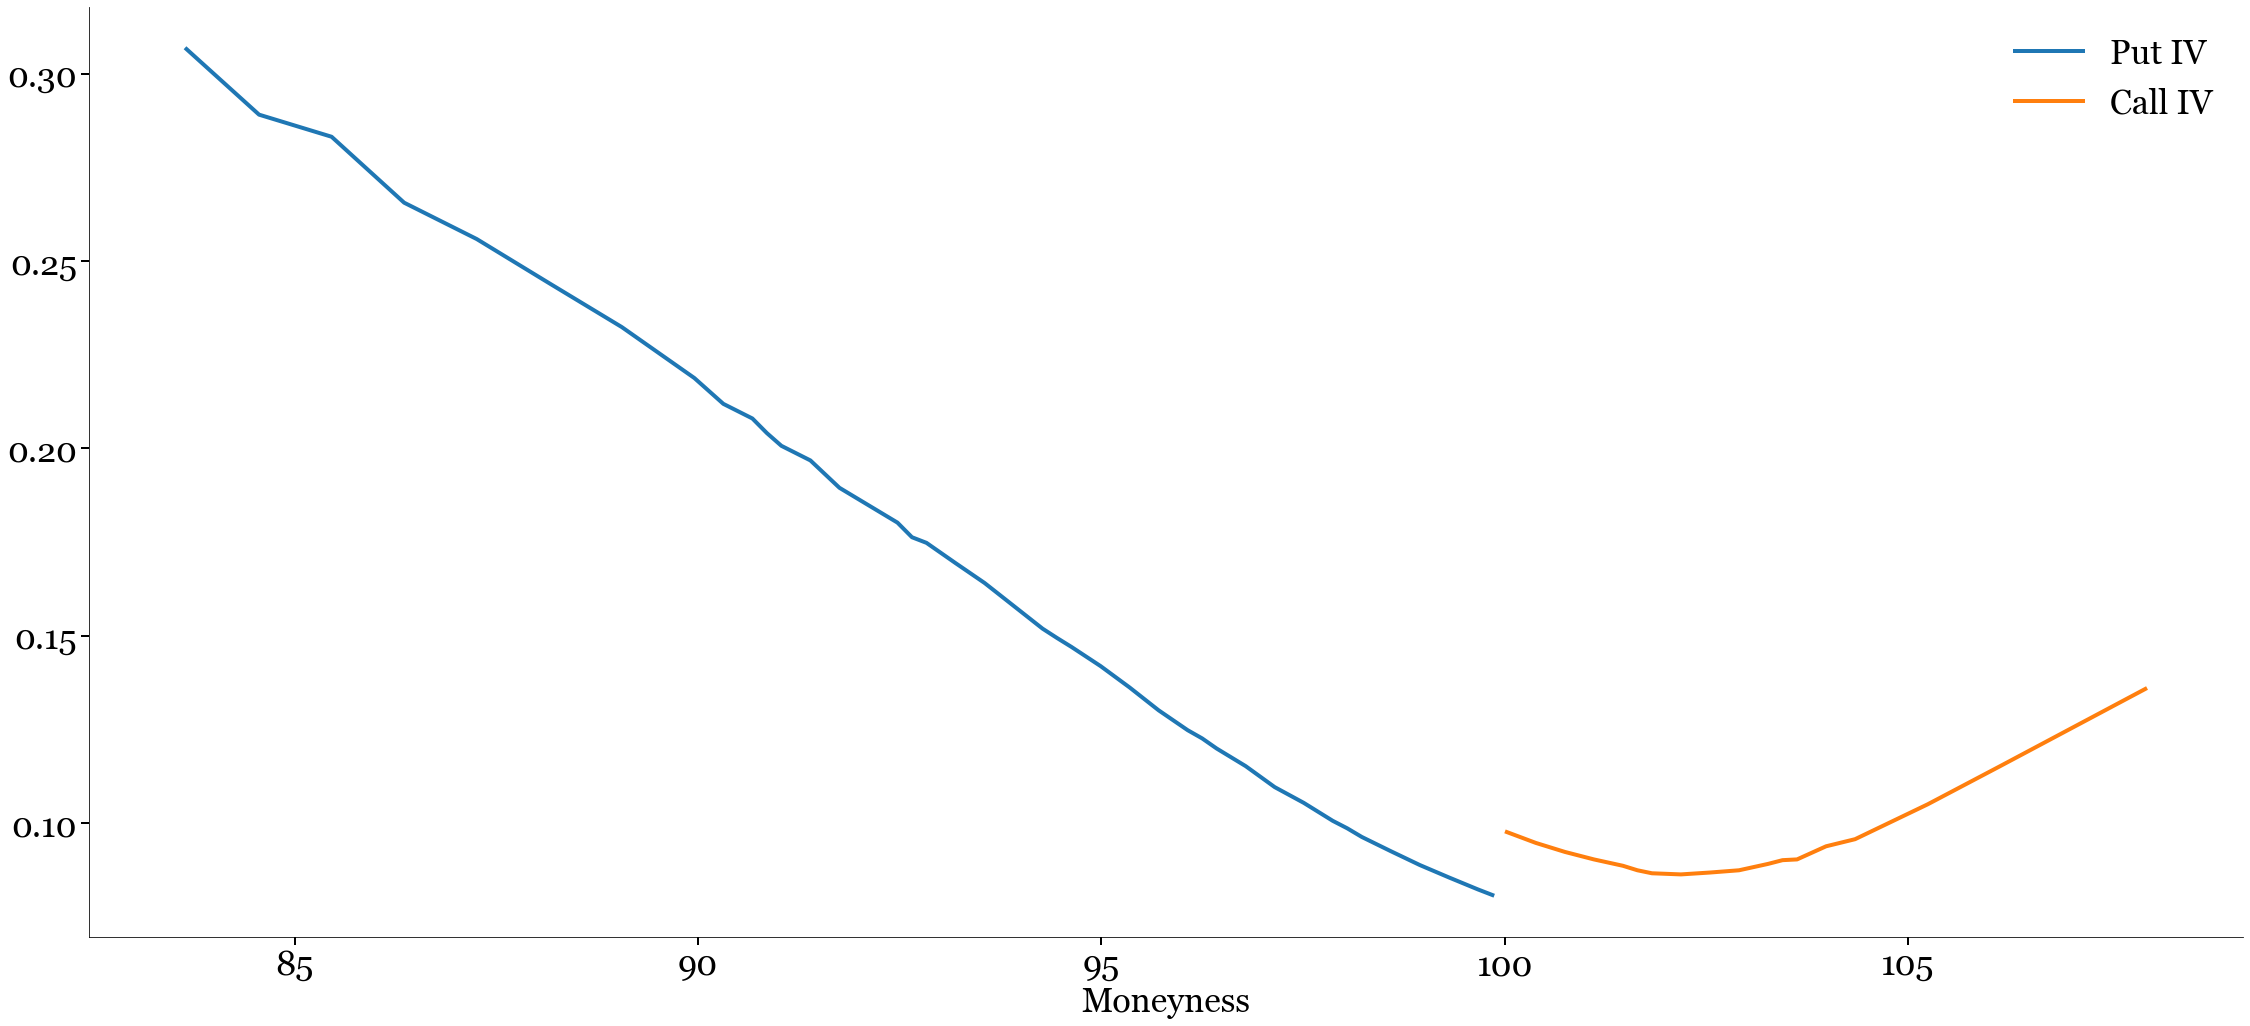

In [2]:
bsiv()

# Model-free Implied Variance

* VIX is continuously computed by the CBOE 
* Uses both out-of-the-monry calls and puts 

$$\sigma^{2}=\frac{2}{T}e^{rT}\sum_{i=1}^{N}\frac{\Delta K_{i}}{K_{i}}\frac{Q(K_{i})}{K_i}-\frac{1}{T}\left(\frac{F_{0}}{K_{0}}-1\right)^{2} $$

* $Q(K_{i})$ is the mid-quote for a strike of $K_{i}$, $K_{0}$ is the first strike below the forward index level 
* VIX appears to have information about future realized volatility that is not in other backward looking measures (GARCH/RV) 
* Computes area under curves defined by OOM options

# 20% Annualized Volatility

In [3]:
# Return the value of the Gaussian probability function with mean 0.0
# and standard deviation 1.0 at the given x value.


def phi(x):
    return math.exp(-x * x / 2.0) / math.sqrt(2.0 * math.pi)


# Return the value of the Gaussian probability function with mean mu
# and standard deviation sigma at the given x value.


def pdf(x, mu=0.0, sigma=1.0):
    return phi((x - mu) / sigma) / sigma


# Return the value of the cumulative Gaussian distribution function
# with mean 0.0 and standard deviation 1.0 at the given z value.


def Phi(z):
    return stats.norm().cdf(z)


# Return standard Gaussian cdf with mean mu and stddev sigma.
# Use Taylor approximation.


def cdf(z, mu=0.0, sigma=1.0):
    return Phi((z - mu) / sigma)


# Black-Scholes formula.


def callPrice(s, x, r, sigma, t):
    a = (math.log(s / x) + (r + sigma * sigma / 2.0) * t) / (sigma * math.sqrt(t))
    b = a - sigma * math.sqrt(t)
    return s * cdf(a) - x * math.exp(-r * t) * cdf(b)


r = 0.02
vol = 0.20
points = np.linspace(60, 140, 401)
points = np.array(points)
points.sort()
cp = np.empty_like(points)
pp = np.empty_like(points)
for i, k in enumerate(points):
    cp[i] = callPrice(100, k, r, vol, 1 / 12)
    d = np.exp(-r * (1 / 12))
    pp[i] = cp[i] - (100 - d * k)


def plot_20():
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    combined_x = []
    combined_y = []

    ind = points > 100
    ax.plot(points[~ind], pp[~ind], color=mfe.colors[1])
    combined_x += points[~ind].tolist()
    combined_y += pp[~ind].tolist()
    ax.plot(points[ind], pp[ind], alpha=0.5, linestyle=":", color=mfe.colors[1])

    ind = points >= 100
    ax.plot(points[ind], cp[ind], color=mfe.colors[0])
    combined_x += points[ind].tolist()
    combined_y += cp[ind].tolist()
    ax.plot(points[~ind], cp[~ind], alpha=0.5, linestyle=":", color=mfe.colors[0])

    cand = (points - points.astype("int")) == 0
    cand &= (points >= 88) & (points <= 116) & (points.astype(int) % 4 == 0)
    cand_points = points[cand]
    cand_put = pp[cand]
    cand_call = cp[cand]
    ind = cand_points <= 100
    ax.plot(
        cand_points[ind],
        cand_put[ind],
        linestyle="none",
        marker="s",
        color=mfe.colors[1],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_put[ind],
        marker="s",
        color=mfe.colors[1],
        markersize=12,
        label="Put Option Price",
    )
    ind = cand_points >= 100
    ax.plot(
        cand_points[ind],
        cand_call[ind],
        linestyle="none",
        marker="o",
        color=mfe.colors[0],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_call[ind],
        marker="o",
        color=mfe.colors[0],
        markersize=12,
        label="Call Option Price",
    )
    ax.set_xlim(points[0], points[-1])
    ax.set_ylim(-0.02, 4)
    ax.set_xticks(np.arange(60, 141, 4))
    ax.set_yticks(np.arange(0, 5))
    combined_x = np.array(combined_x)
    combined_y = np.array(combined_y)
    ax.fill_between(
        combined_x, combined_y, alpha=0.33, label="VIX Area", color=mfe.colors[7]
    )
    ax.legend(frameon=False)
    ax.set_ylabel("Option Price")
    ax.set_xlabel("Strike Price")
    sns.despine()
    fig.tight_layout(pad=1.0)

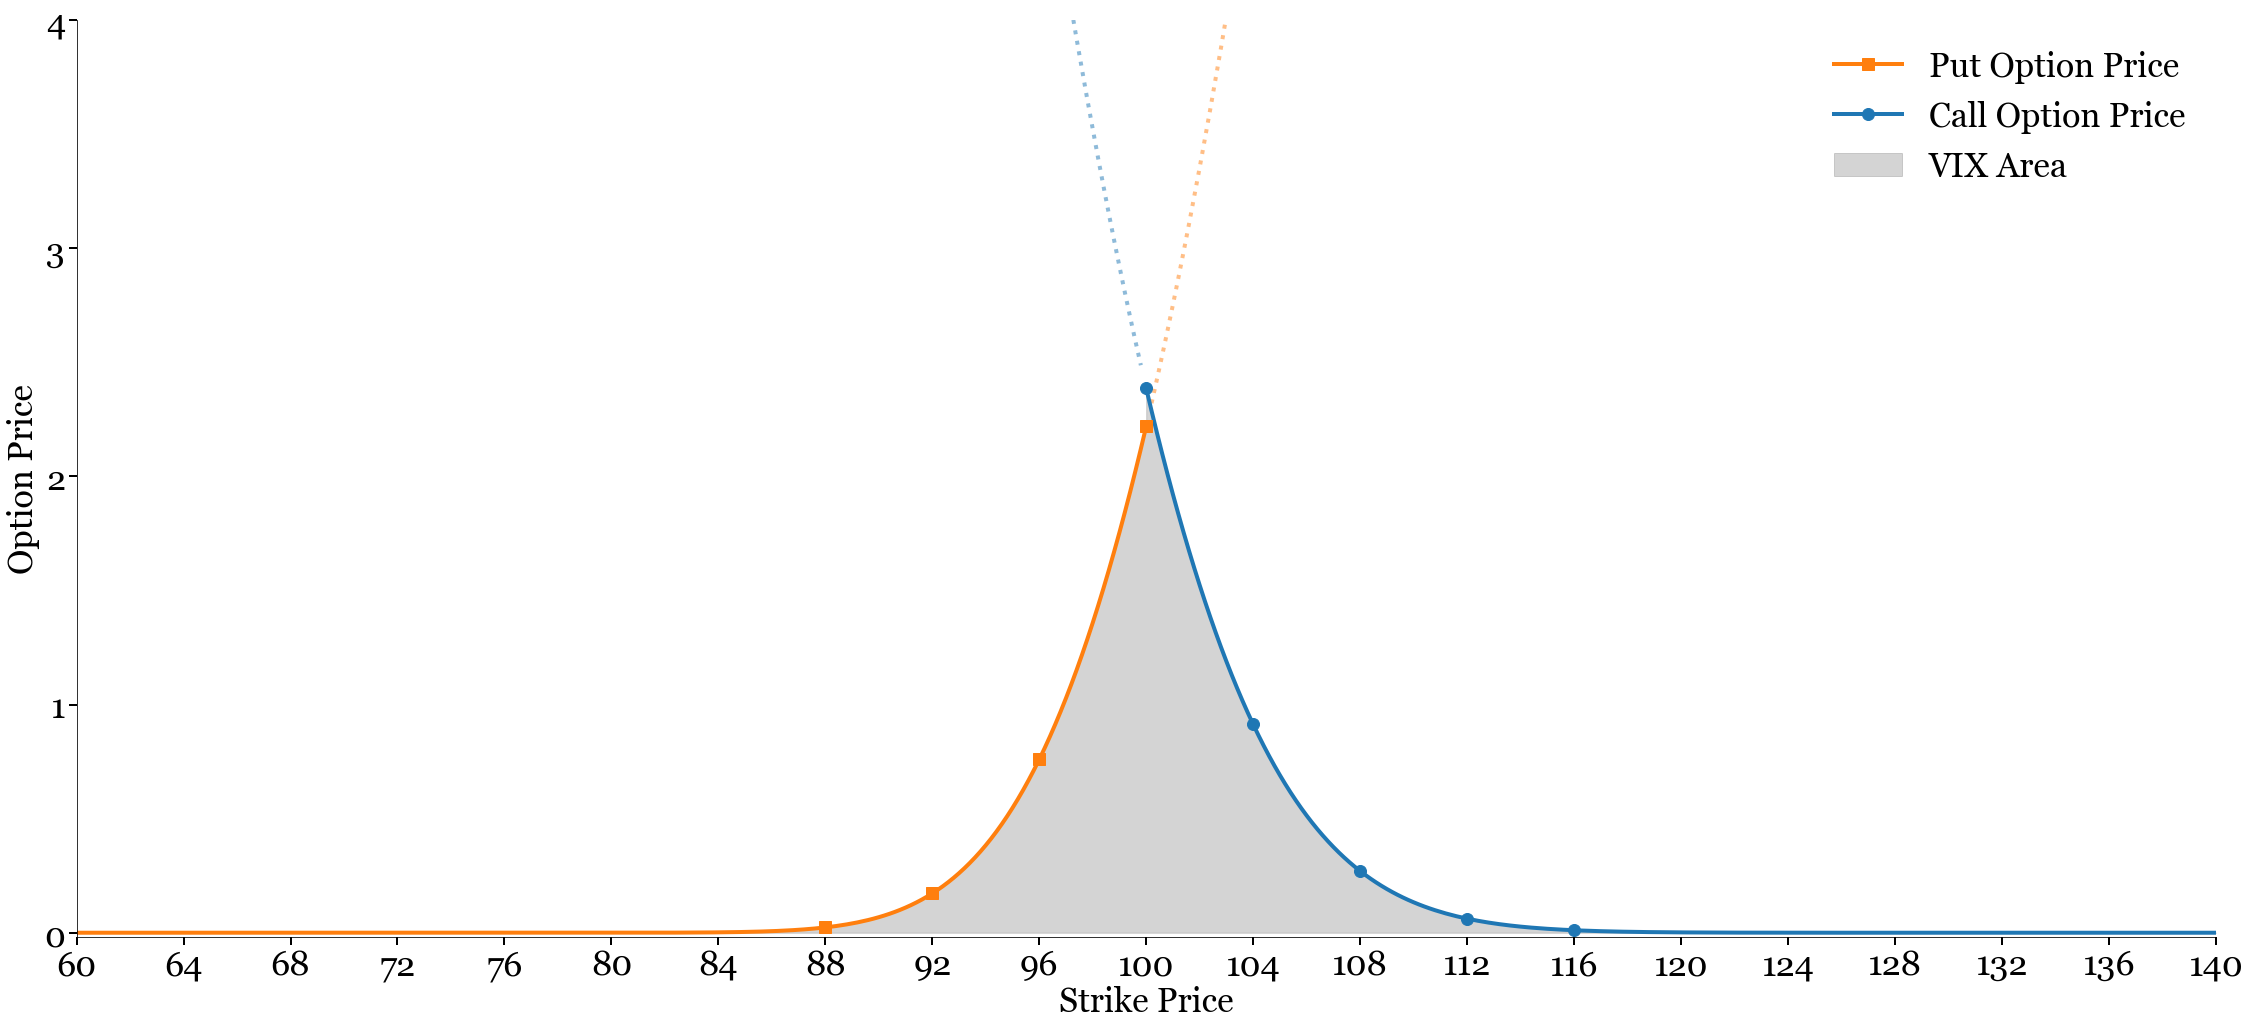

In [4]:
plot_20()

In [5]:
#%%

r = 0.02
vol = 0.60
points = np.linspace(60, 140, 401)
points = np.array(points)
points.sort()
cp = np.empty_like(points)
pp = np.empty_like(points)
for i, k in enumerate(points):
    cp[i] = callPrice(100, k, r, vol, 1 / 12)
    d = np.exp(-r * (1 / 12))
    pp[i] = cp[i] - (100 - d * k)


def plot_60():
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    combined_x = []
    combined_y = []

    ind = points > 100
    ax.plot(points[~ind], pp[~ind], color=mfe.colors[1])
    combined_x += points[~ind].tolist()
    combined_y += pp[~ind].tolist()
    ax.plot(points[ind], pp[ind], alpha=0.5, linestyle=":", color=mfe.colors[1])

    ind = points >= 100
    ax.plot(points[ind], cp[ind], color=mfe.colors[0])
    combined_x += points[ind].tolist()
    combined_y += cp[ind].tolist()
    ax.plot(points[~ind], cp[~ind], alpha=0.5, linestyle=":", color=mfe.colors[0])

    cand = (points - points.astype("int")) == 0
    cand &= (points >= 40) & (points <= 160) & (points.astype(int) % 4 == 0)
    cand_points = points[cand]
    cand_put = pp[cand]
    cand_call = cp[cand]
    ind = cand_points <= 100
    ind &= (cand_put > 0.01) & (cand_call > 0.01)
    ax.plot(
        cand_points[ind],
        cand_put[ind],
        linestyle="none",
        marker="s",
        color=mfe.colors[1],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_put[ind],
        marker="s",
        color=mfe.colors[1],
        markersize=12,
        label="Put Option Price",
    )
    ind = cand_points >= 100
    ax.plot(
        cand_points[ind],
        cand_call[ind],
        linestyle="none",
        marker="o",
        color=mfe.colors[0],
        markersize=12,
    )
    ax.plot(
        cand_points[ind] - 1000,
        cand_call[ind],
        marker="o",
        color=mfe.colors[0],
        markersize=12,
        label="Call Option Price",
    )
    ax.set_xlim(points[0], points[-1])
    ax.set_ylim(-0.02, 10)
    ax.set_xticks(np.arange(60, 141, 4))
    ax.set_yticks(np.arange(0, 11, 2))
    combined_x = np.array(combined_x)
    combined_y = np.array(combined_y)
    ax.fill_between(
        combined_x, combined_y, alpha=0.33, label="VIX Area", color=mfe.colors[7]
    )
    ax.legend(frameon=False)
    ax.set_ylabel("Option Price")
    ax.set_xlabel("Strike Price")
    sns.despine()
    fig.tight_layout(pad=1.0)

# 60% Annualized Volatility

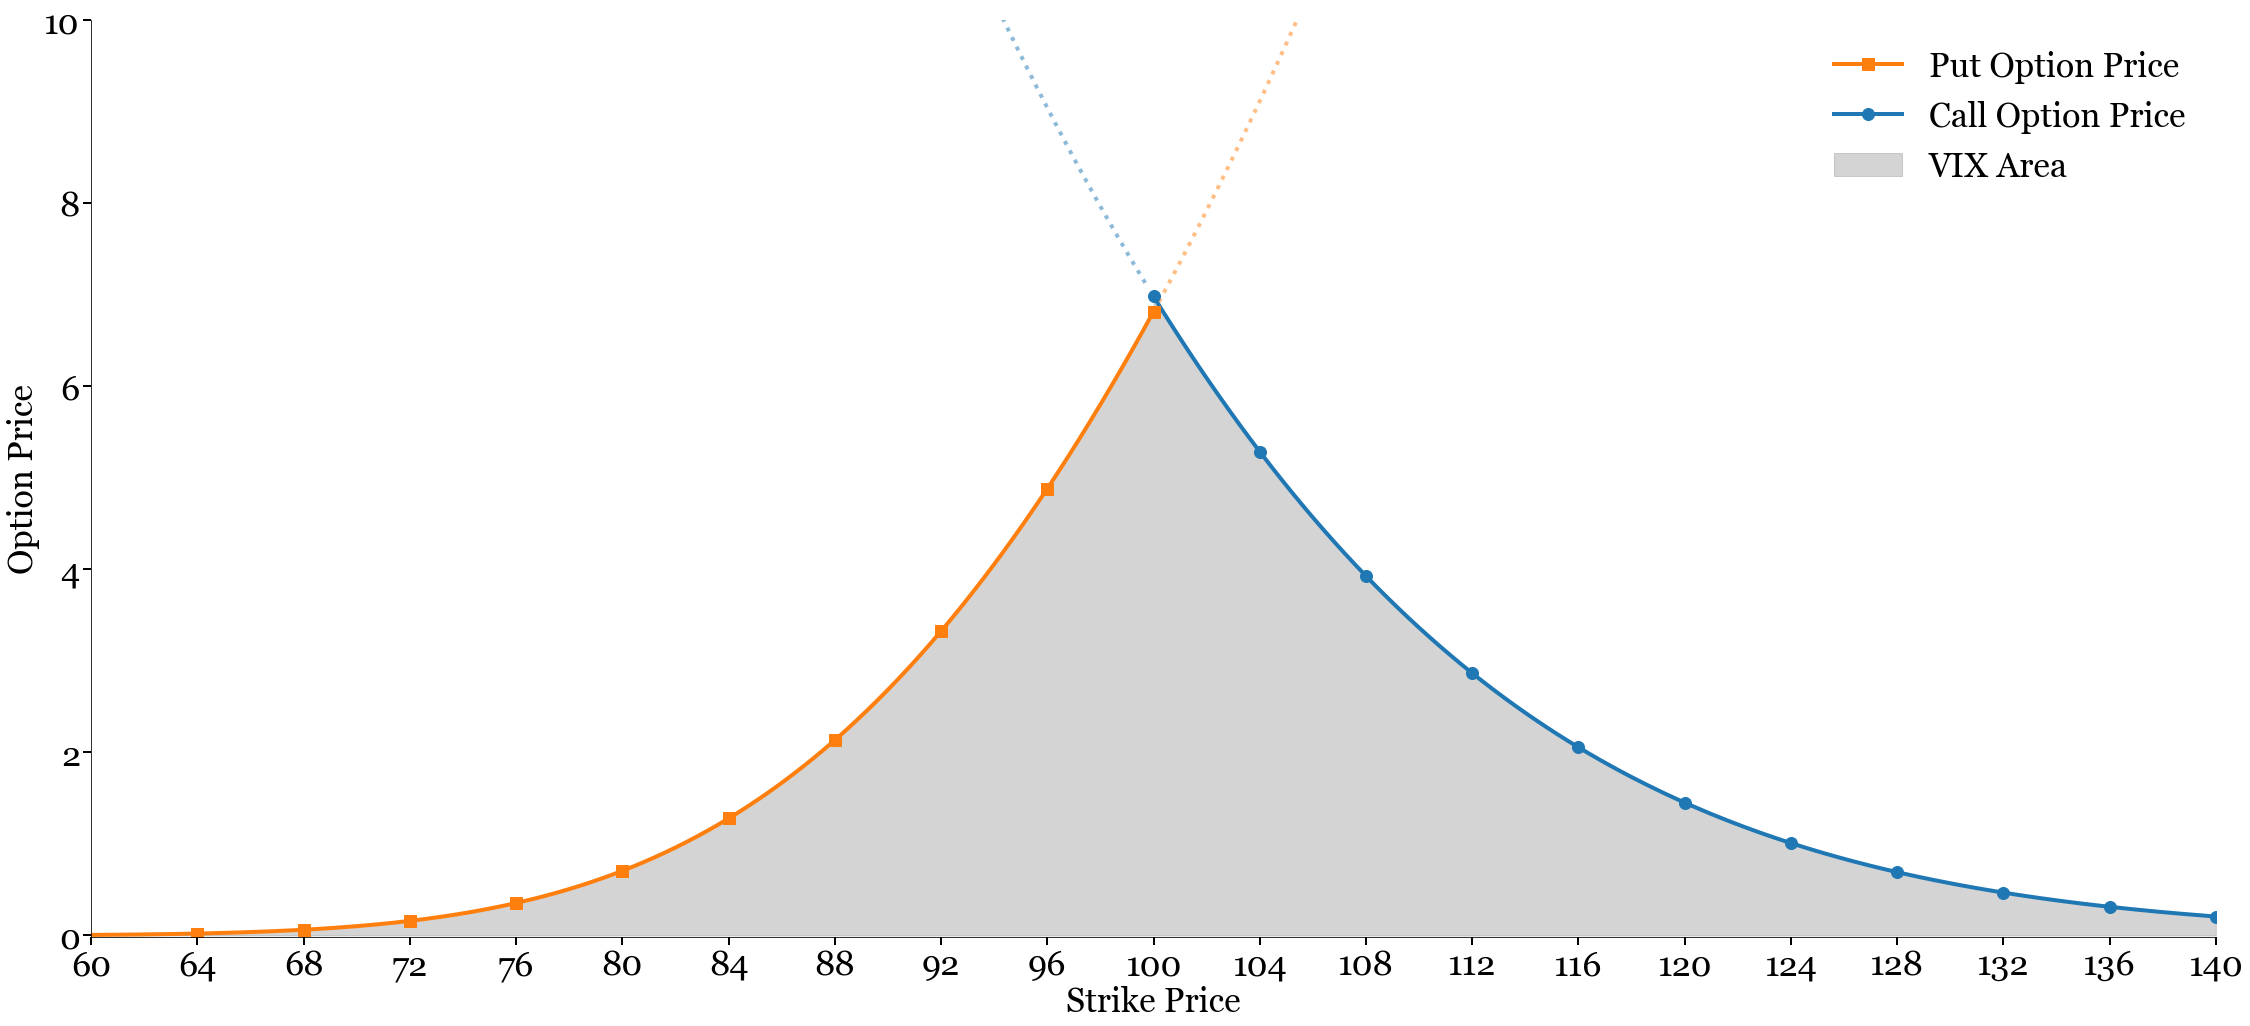

In [6]:
plot_60()

# Value-at-Risk 

* Defining VaR
* Changed in the future return distribution and VaR
* Volatility-based VaR models
* CaViaR
* Weighted Historical Simulation
* VaR model evaluation


In [7]:
import pandas as pd

with pd.HDFStore("univariate-volatility-data.h5", "r") as store:
    sp500 = store.get("sp500")

# Percentage Value-at-Risk

## Defined

The $\alpha$ percentage Value-at-Risk (%VaR) of a portfolio is defined as the largest return such that the probability that the return on the portfolio over some period of time is less than -%VaR is $\alpha$

$$ \mathrm{Pr}(r<-\text{%}\textrm{VaR})=\alpha$$

where $r$ is the percentage return on the portfolio.

* I will use VaR interchangeably with %VaR
* Usually interested in _conditional_ VaR

$$ \mathrm{Pr}(r_{t+1}<-\text{%}\textrm{VaR}_{t+1}|\mathcal{F}_{t})=\alpha$$

# The Effect of Changes in Mean

* VaR has an inverse relationship to the mean of a portfolio
* The mean always enters additively

$$ \text{VAR} = -\mu + \text{other terms} $$

* Higher mean reduces VaR


In [8]:
mu = 0.005
sigma = np.sqrt(0.2 ** 2 / 12)


def plot_mean_shift():
    x = mu + sigma * np.linspace(-3, 3, 601)
    n1 = stats.norm(mu, sigma)
    y = n1.pdf(x)
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    ax.plot(x, y)
    n2 = stats.norm(3 * mu, sigma)
    y2 = n2.pdf(x)
    ax.plot(x, y2)
    ax.set_xlim(np.amin(x), np.amax(x))
    ax.set_ylim(0, ax.get_ylim()[-1])
    yl = ax.get_ylim()
    ax.plot([0, 0], yl, "k:")
    ax.set_ylim(yl)
    loc = n1.ppf(0.05)
    ax.plot([loc, loc], [0, n1.pdf(loc)], color=mfe.colors[0], linestyle="--")
    ax.plot(
        [0, loc],
        [0.8, 0.8],
        color=mfe.colors[0],
        linestyle=":",
        label="VaR $\mu=0.5\%$",
    )
    loc = n2.ppf(0.05)
    ax.plot([loc, loc], [0, n2.pdf(loc)], color=mfe.colors[1], linestyle="--")
    ax.plot(
        [0, loc],
        [0.2, 0.2],
        color=mfe.colors[1],
        linestyle=":",
        label="VaR $\mu=1.5\%$",
    )
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)
    sns.despine()


def plot_std_change():
    x = mu + sigma * np.linspace(-3, 3, 601)
    n1 = stats.norm(mu, sigma)
    y = n1.pdf(x)
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    ax.plot(x, y)
    n2 = stats.norm(mu, 1.5 * sigma)
    y2 = n2.pdf(x)
    ax.plot(x, y2)
    ax.set_xlim(np.amin(x), np.amax(x))
    ax.set_ylim(0, ax.get_ylim()[-1])
    yl = ax.get_ylim()
    ax.plot([0, 0], yl, "k:")
    ax.set_ylim(yl)
    loc = n2.ppf(0.05)
    ax.plot([loc, loc], [0, n2.pdf(loc)], color=mfe.colors[1], linestyle="--")
    ax.plot(
        [0, loc],
        [0.2, 0.2],
        color=mfe.colors[1],
        linestyle=":",
        label="VaR Ann. $\sigma=30\%$",
    )
    loc = n1.ppf(0.05)
    ax.plot([loc, loc], [0, n1.pdf(loc)], color=mfe.colors[0], linestyle="--")
    ax.plot(
        [0, loc],
        [0.8, 0.8],
        color=mfe.colors[0],
        linestyle=":",
        label="VaR Ann. $\sigma=20\%$",
    )
    ax.legend(frameon=False)
    fig.tight_layout(pad=1.0)
    sns.despine()

# Mean Shifts

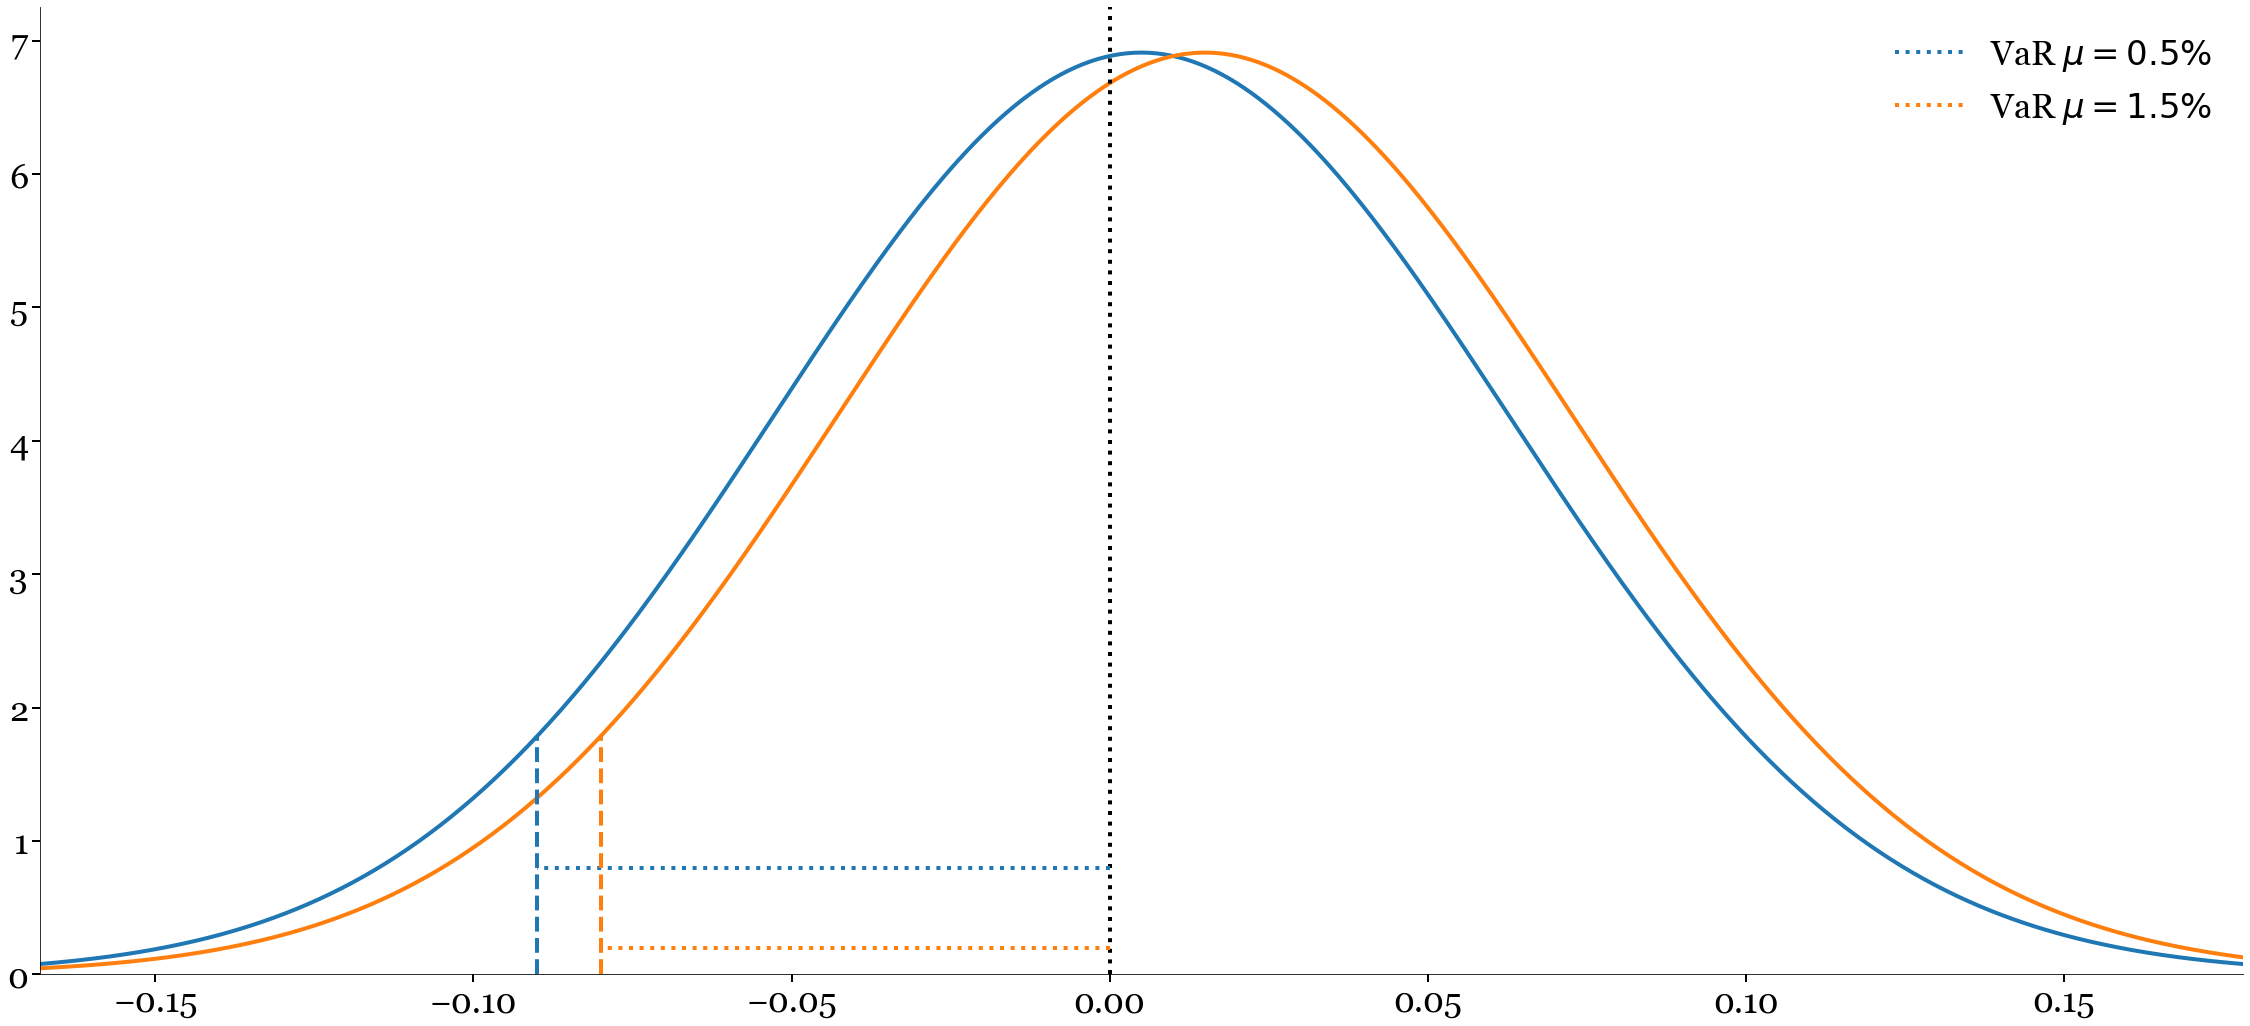

In [9]:
plot_mean_shift()

# The Effect of Changes in Standard Deviation

* VaR has an linear relationship to the standard deviation of a portfolio
* The standard deviation always enters multiplicatively

$$ \text{VAR} = -\mu - \sigma F^{-1}(\alpha) $$

* $F^{-1}(\alpha)$ is the _quantile_ function
  * For relevant $\alpha$ (1%, 5%), $F^{-1}(\alpha)$ is _negative_
* Higher standard deviation increases  VaR

# Standard Deviation Changes

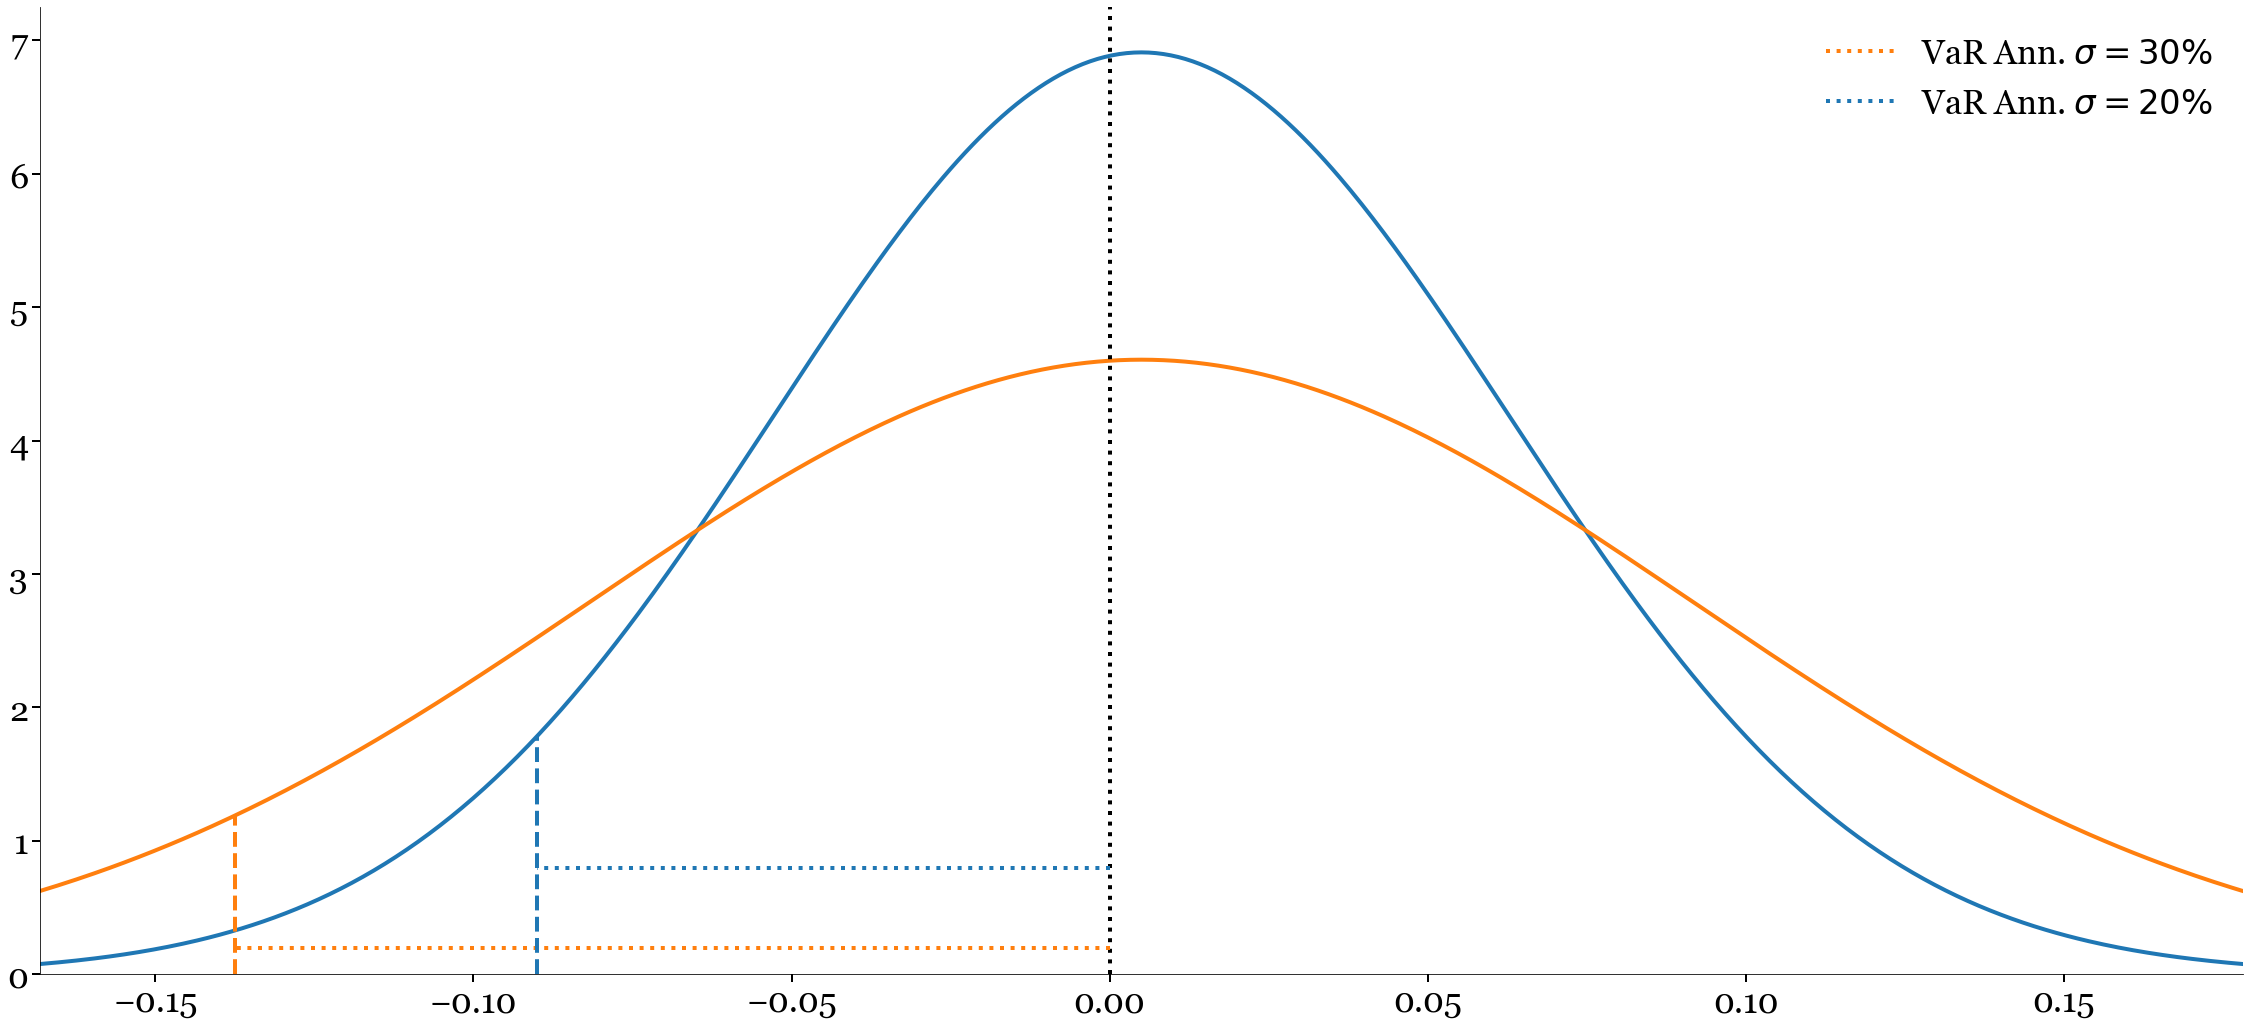

In [10]:
plot_std_change()

# Connection to Quantiles

* The VaR crucially depends on the _quantile_ of the future return distribution

$$ VaR = -q_{\alpha} $$

* In principle only need to model $q_\alpha$

# Connection to Quantiles

In [11]:
def quantile_plot():
    fig, ax = plt.subplots(1, 1, figsize=mfe.DEFAULT_FIGSIZE)
    x = np.linspace(-3, 3, 601)
    n = stats.norm()
    y = n.cdf(x)
    plt.plot(x, y, "k")
    ax.set_ylim(0, 1)
    ax.set_xlim(-3, 3)
    ax.plot([-3, n.ppf(0.1)], [0.1, 0.1], "--", color=mfe.colors[0])
    ax.plot([n.ppf(0.1), n.ppf(0.1)], [0, 0.1], "--", color=mfe.colors[0])
    xt = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.set_yticks(xt)
    xtl = [f"{v:0.1f}" for v in xt]
    xtl[1] = r"$\alpha$"
    ax.set_yticklabels(xtl)
    yt = [i for i in range(-3, 4)]
    ytl = [str(t) for t in yt]
    yt.insert(2, n.ppf(0.1))
    ytl.insert(2, r"$q_\alpha$")
    ax.set_xticks(yt)
    ax.set_xticklabels(ytl)
    sns.despine()
    fig.tight_layout(pad=1.0)

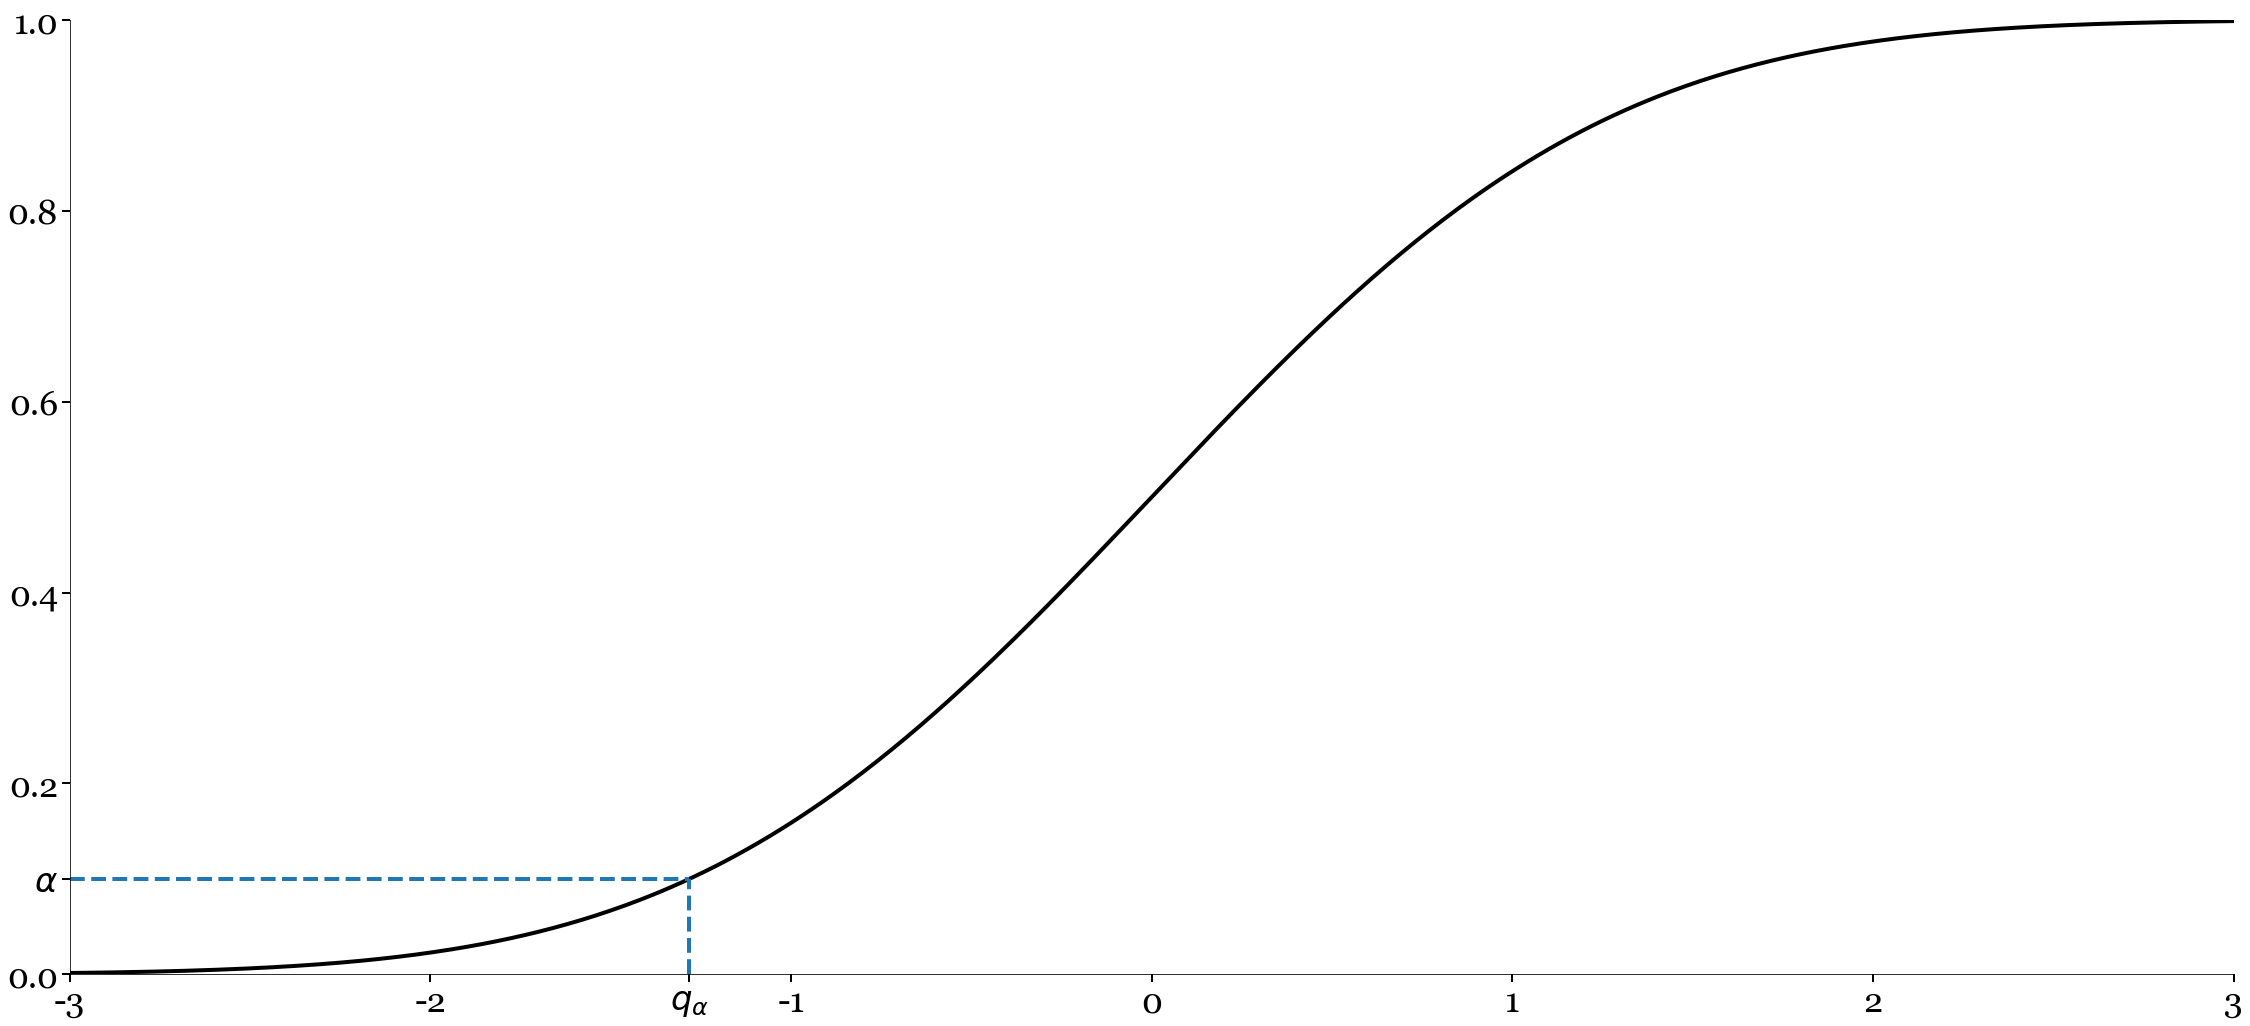

In [12]:
quantile_plot()

# RiskMetrics

* Exponentially Weighted Moving Average (EWMA) Variance:

$$\sigma_{t+1}^{2}=(1-\lambda)r_{t}^{2}+\lambda\sigma_{t}^{2}$$

$$\text{VaR}_{t+1}=-\sigma_{t+1}\Phi^{-1}(\alpha)$$

* $\Phi^{-1}(\cdot)$ is the inverse normal cdf 
* $\lambda$ is a known, fixed value
  * .94 (daily data)
  * .97 (weekly)
  * .99 (monthly) 

# RiskMetrics Variance Forecasts

In [13]:
from arch.univariate import EWMAVariance, ZeroMean

vol = EWMAVariance(0.94)
mod = ZeroMean(sp500, volatility=vol)
res = mod.fit()
start = sp500.index[sp500.index.shape[0] // 2]
fcasts = res.forecast(start=start, horizon=10)
fcast_variance = fcasts.variance.dropna(how="all")

In [14]:
fcast_variance.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,1.458982,1.458982,1.458982,1.458982,1.458982,1.458982,1.458982,1.458982,1.458982,1.458982
2000-06-30,1.414438,1.414438,1.414438,1.414438,1.414438,1.414438,1.414438,1.414438,1.414438,1.414438
2000-07-03,1.392867,1.392867,1.392867,1.392867,1.392867,1.392867,1.392867,1.392867,1.392867,1.392867
2000-07-05,1.460259,1.460259,1.460259,1.460259,1.460259,1.460259,1.460259,1.460259,1.460259,1.460259
2000-07-06,1.403911,1.403911,1.403911,1.403911,1.403911,1.403911,1.403911,1.403911,1.403911,1.403911


# RiskMetrics Value-at-Risk

* VaR scales with $\sqrt{h}$ rule
* Driven by assumption of constant variance and no serial correlation

In [15]:
alpha = 0.01
value_at_risk = -np.sqrt(fcast_variance.cumsum(axis=1)) * stats.norm().ppf(alpha)

In [16]:
value_at_risk.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,2.809957,3.973880,4.866989,5.619914,6.283255,6.882961,7.434448,7.947759,8.429871,8.885865
2000-06-30,2.766729,3.912746,4.792115,5.533458,6.186594,6.777075,7.320077,7.825492,8.300187,8.749166
2000-07-03,2.745551,3.882795,4.755433,5.491101,6.139238,6.725198,7.264044,7.765590,8.236652,8.682193
2000-07-05,2.811187,3.975618,4.869118,5.622373,6.286004,6.885973,7.437701,7.951236,8.433560,8.889752
2000-07-06,2.756414,3.898158,4.774248,5.512827,6.163528,6.751807,7.292785,7.796315,8.269241,8.716545


# Risk Metrics Value-at-Risk

In [17]:
rm_final = value_at_risk.iloc[-1]
rm_final.index = np.arange(1, 11)

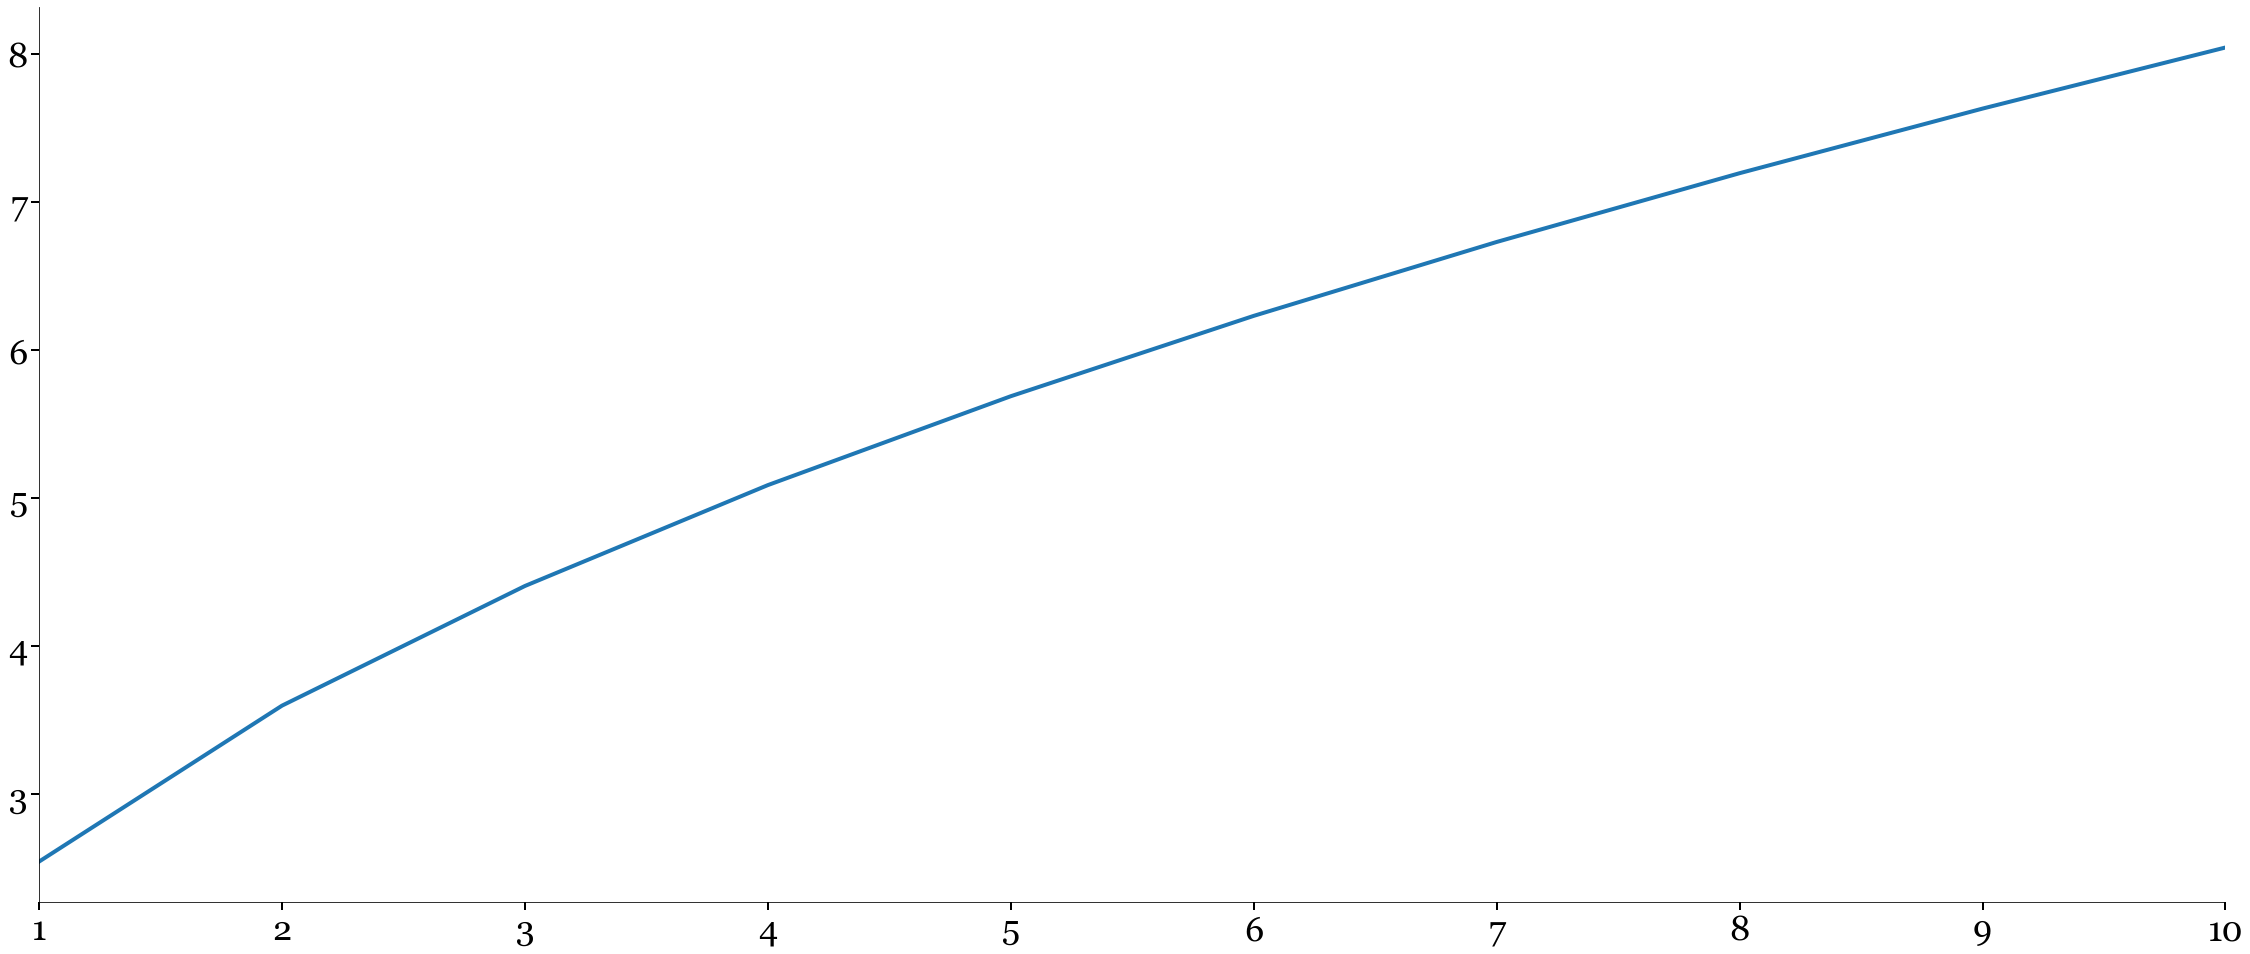

In [18]:
plot(rm_final)

# Parameteric GARCH

$$r_{t+1}	=\mu+\epsilon_{t+1}$$
$$\sigma_{t+1}^{2}	=\omega+\gamma\epsilon_{t}^{2}+\beta\sigma_{t}^{2}$$
$$\epsilon_{t+1}	=\sigma_{t+1}e_{t+1}$$
$$e_{t+1}	\stackrel{iid}{\sim} F(0,1)$$

• Value-at-Risk

$$\text{VaR}_{t+1}=-\hat{\mu}-\hat{\sigma}_{t+1}F_{\alpha}^{-1}$$

# Skew-$t$ GJR-GARCH

In [19]:
gjr = arch_model(sp500, o=1, power=2.0, dist="skewt").fit(disp="off")
summary(gjr, [1, 2])

,coef,std err,t,P>|t|,95.0% Conf. Int.
mu,0.0390,7.739e-03,5.041,4.632e-07,"[2.384e-02,5.418e-02]"


,coef,std err,t,P>|t|,95.0% Conf. Int.
omega,0.0161,2.717e-03,5.909,3.446e-09,"[1.073e-02,2.138e-02]"
alpha[1],0.0209,4.811e-03,4.342,1.410e-05,"[1.146e-02,3.032e-02]"
gamma[1],0.1331,1.536e-02,8.666,4.459e-18,"[ 0.103, 0.163]"
beta[1],0.8999,8.634e-03,104.231,0.000,"[ 0.883, 0.917]"


In [20]:
fcasts = gjr.forecast(start=start, horizon=10)
fcast_variance = fcasts.variance.dropna(how="all")

# Variance forecast is mean reverting

In [21]:
fcast_variance.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,1.136292,1.138025,1.139736,1.141426,1.143094,1.144741,1.146367,1.147973,1.149558,1.151124
2000-06-30,1.052276,1.055068,1.057825,1.060547,1.063234,1.065888,1.068508,1.071095,1.073650,1.076172
2000-07-03,0.983440,0.987100,0.990713,0.994281,0.997804,1.001282,1.004717,1.008108,1.011457,1.014763
2000-07-05,1.307899,1.307469,1.307044,1.306624,1.306210,1.305801,1.305397,1.304998,1.304604,1.304216
2000-07-06,1.202832,1.203726,1.204609,1.205481,1.206341,1.207191,1.208030,1.208859,1.209677,1.210485


In [22]:
alpha = 0.01
h = np.arange(1, 11)
mu = gjr.params["mu"]
shape = gjr.params[["nu", "lambda"]]
q = gjr.model.distribution.ppf(alpha, parameters=shape)
gjr_value_at_risk = -h * mu - np.sqrt(fcast_variance.cumsum(axis=1)) * q

# Skew $t$ GJR-GARCH Value-at-Risk

* Scaling is not $\sqrt{h}$
* Simple method ignores effect of changing variance

In [23]:
print(f"Skew t alpha={alpha:0.02f} Quantile: {q:0.3f}")

Skew t alpha=0.01 Quantile: -2.655


In [24]:
gjr_value_at_risk.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,2.790671,3.925279,4.787841,5.509737,6.141830,6.710195,7.230313,7.712268,8.163059,8.587780
2000-06-30,2.684051,3.775523,4.605676,5.300817,5.909830,6.457766,6.959493,7.424692,7.860080,8.270544
2000-07-03,2.593478,3.648342,4.451013,5.123486,5.712962,6.243619,6.729804,7.180854,7.603247,8.001693
2000-07-05,2.996835,4.214960,5.140346,5.914163,6.591099,7.199202,7.755137,8.269762,8.750621,9.203207
2000-07-06,2.872344,4.040021,4.927448,5.669885,6.319711,6.903783,7.438052,7.932910,8.395570,8.831286


In [25]:
gjr_final = gjr_value_at_risk.iloc[-1]
gjr_final.index = np.arange(1, 11)
df = pd.concat([gjr_final, rm_final], 1)
df.columns = ["GJR", "RM"]

# Skew $t$ GJR-GARCH VaR

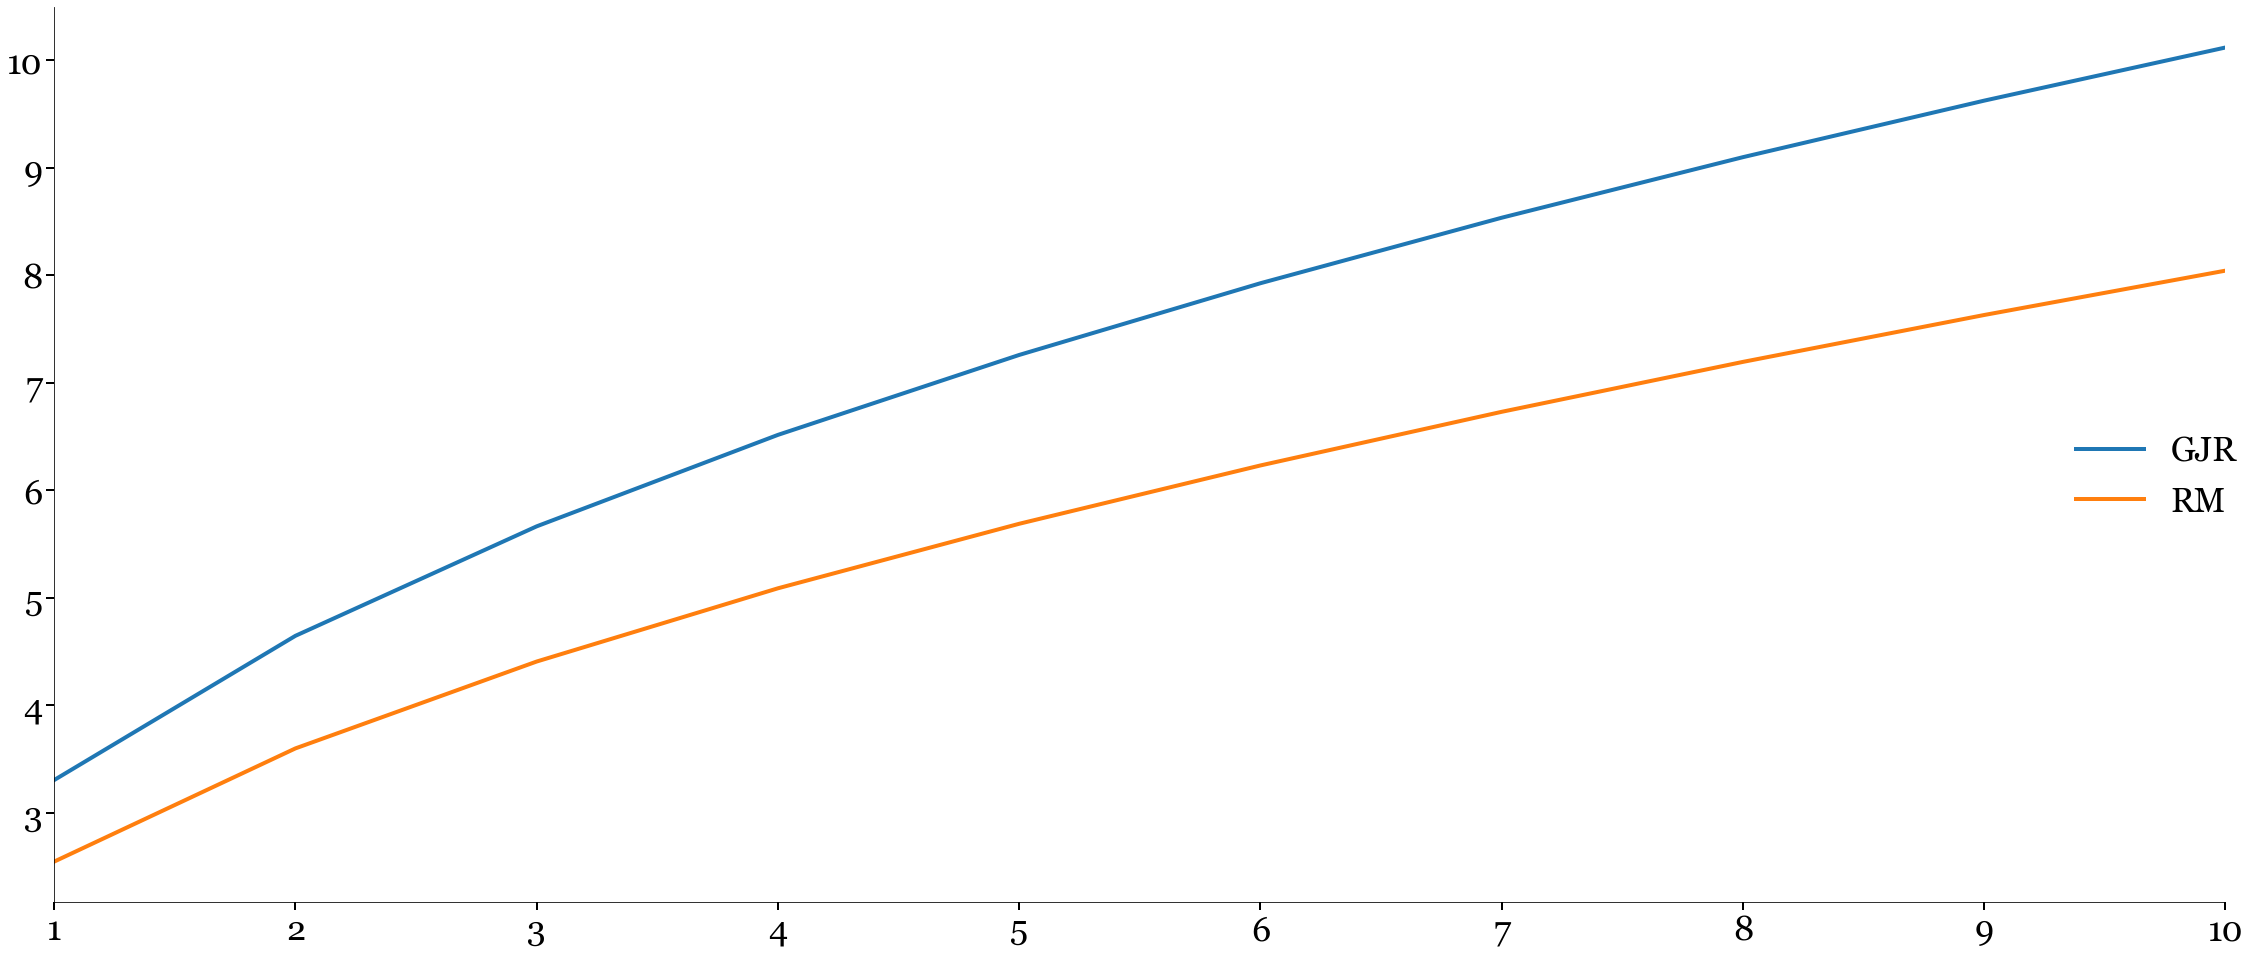

In [26]:
plot(df, loc=5)

# Filtered Historical Simulation

$$r_{t+1}	=\mu+\epsilon_{t+1}$$
$$\sigma_{t+1}^{2}	=\omega+\gamma\epsilon_{t}^{2}+\beta\sigma_{t}^{2}$$
$$\epsilon_{t+1}	=\sigma_{t+1}e_{t+1}$$
$$e_{t+1}	\stackrel{iid}{\sim} G(0,1)$$

* $G$ unknown
* Use empirical CDF to directly estimate quantile

In [27]:
def cdf_plot(x):
    x = x.sort_values()
    data = []
    cdf = 0.0
    step = 1.0 / x.shape[0]
    for i in range(x.shape[0]):
        data.append([x.iloc[i], cdf])
        if i < x.shape[0] - 1:
            data.append([x.iloc[i + 1], cdf])
        cdf += step
    cdf_data = pd.DataFrame(data, columns=["e", "Empirical cdf"])
    plot(cdf_data.set_index("e"), loc=5)

# Empirical CDFs

* Empirical CDFs are step functions
* Formally defined as 

$$ \hat{G}(x) = \frac{1}{n} \sum_{i=1}^n I_{[x<x_i]} $$

* In practice trivial to invert using the sorted values $x_i$

In [28]:
gjr_normal = arch_model(sp500, o=1, power=2.0).fit(disp="off")

# The Empirical cdf of $e$

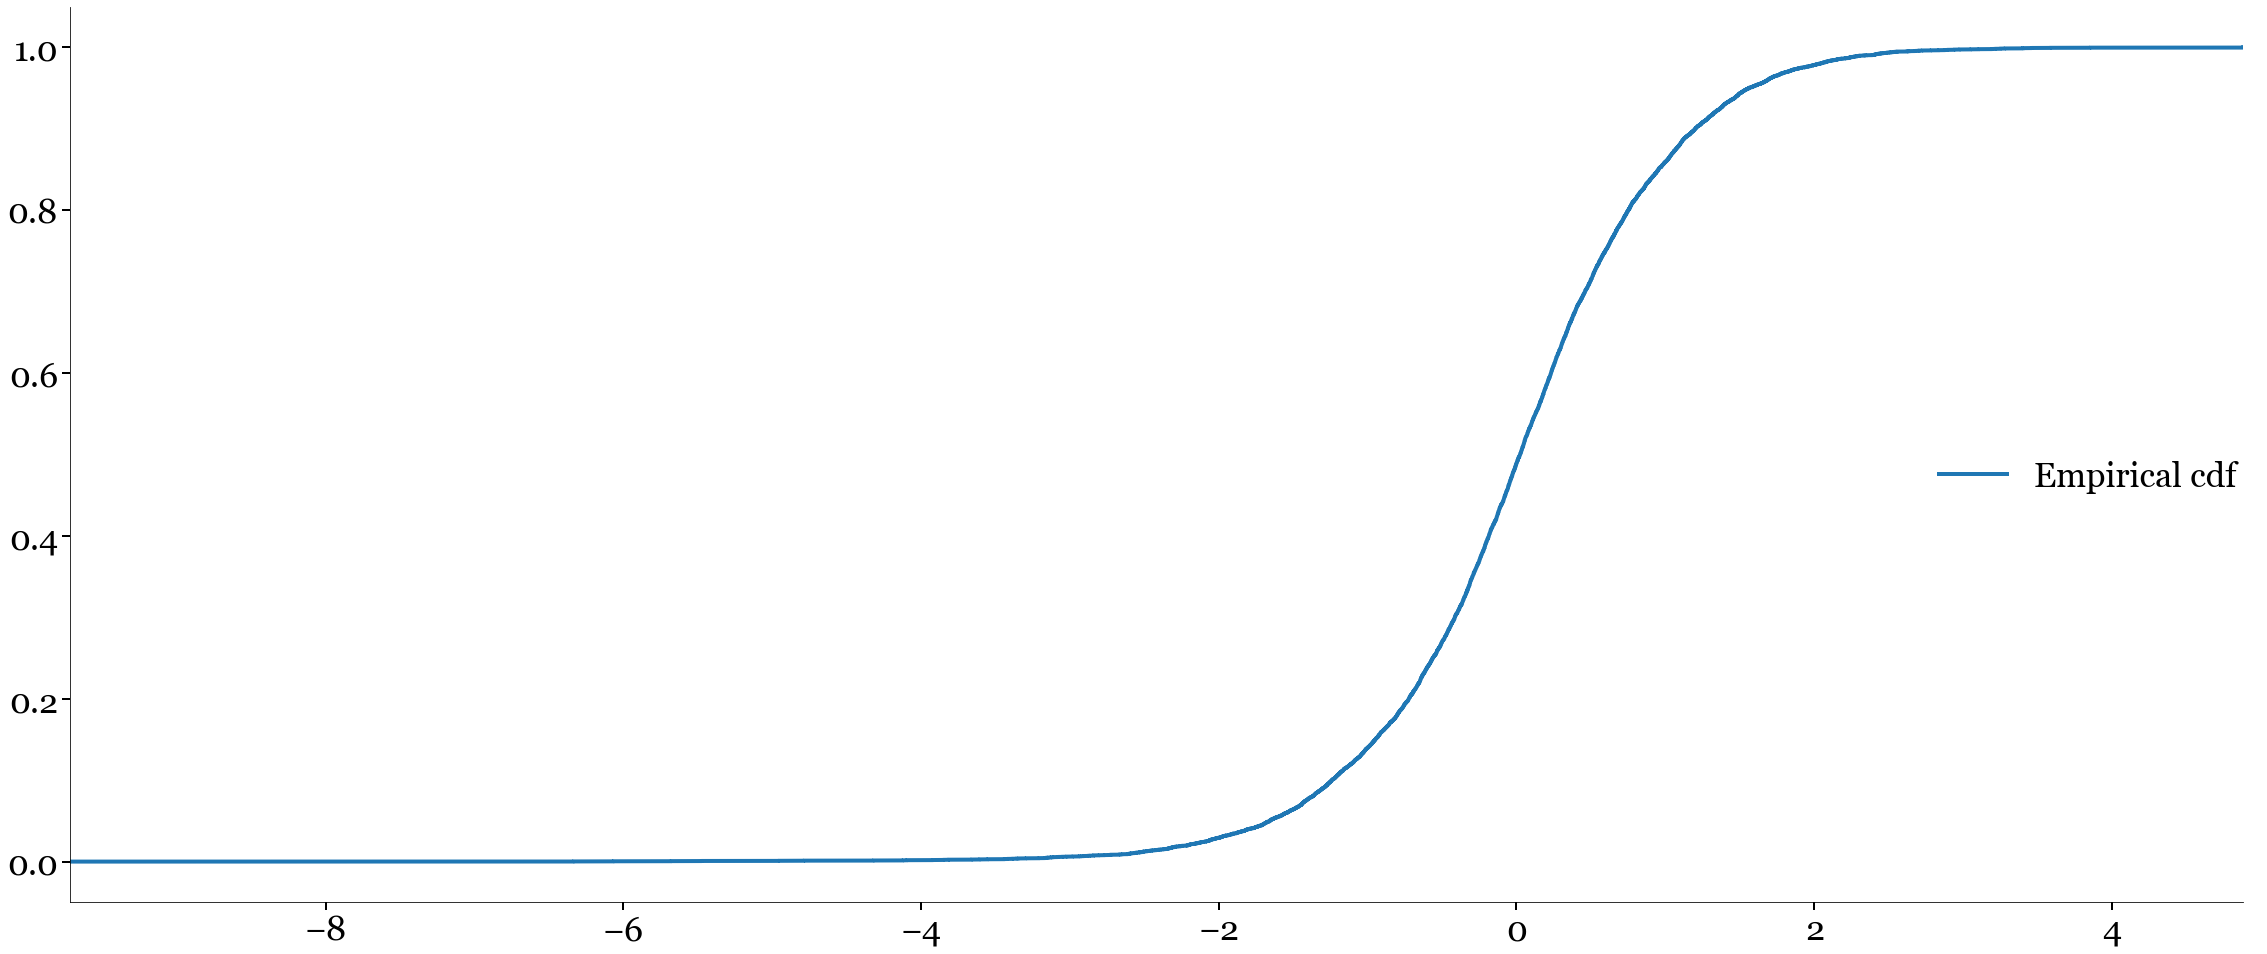

In [29]:
e = gjr_normal.std_resid
cdf_plot(e)

# The Empirical cdf of $e$

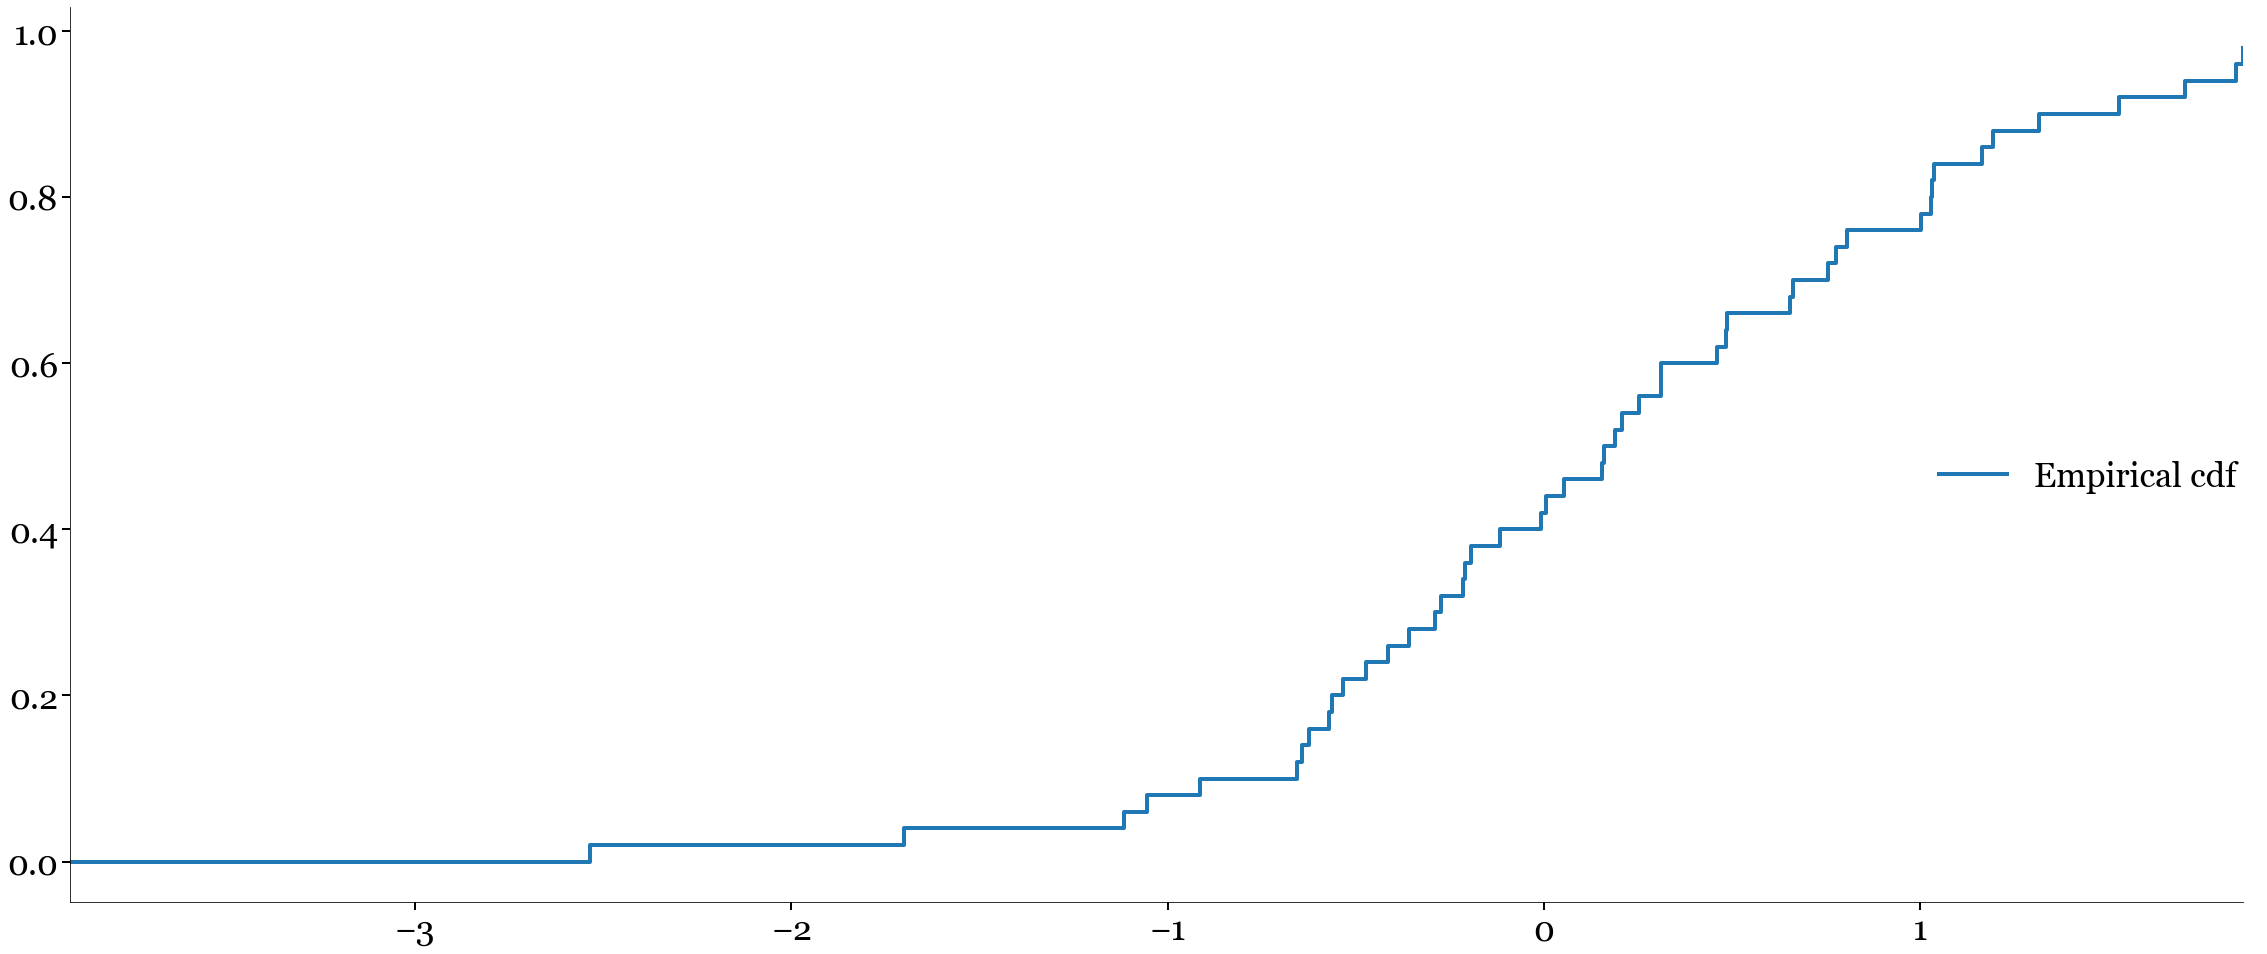

In [30]:
cdf_plot(e.iloc[-50:])

In [31]:
tau = int(e.shape[0] * 0.01)
q = e.sort_values().iloc[tau]
gjr_fhs_value_at_risk = -h * mu - np.sqrt(fcast_variance.cumsum(axis=1)) * q

# FHS VaR

In [32]:
print(f"Empirical cdf alpha={alpha} Quantile: {q:0.3f}")

Empirical cdf alpha=0.01 Quantile: -2.590


In [33]:
gjr_fhs_value_at_risk.head()

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2000-06-29,2.721996,3.828120,4.668801,5.372230,5.988035,6.541659,7.048208,7.517519,7.956422,8.369889
2000-06-30,2.617963,3.681998,4.491057,5.168380,5.761666,6.295357,6.783960,7.236922,7.660796,8.060352
2000-07-03,2.529588,3.557904,4.340147,4.995353,5.569575,6.086407,6.559845,6.999002,7.410197,7.798026
2000-07-05,2.923156,4.110770,5.012751,5.766841,6.426401,7.018798,7.560294,8.061483,8.529725,8.970379
2000-07-06,2.801686,3.940077,4.805020,5.528491,6.161599,6.730549,7.250905,7.732806,8.183291,8.607485


# Comparing VaR Models

In [34]:
gjr_fhs_value_at_risk = gjr_fhs_value_at_risk.iloc[-1]
gjr_fhs_value_at_risk.index = np.arange(1, 11)
df = pd.concat([gjr_fhs_value_at_risk, gjr_final, rm_final], 1)
df.columns = ["FHS", "GJR", "RM"]

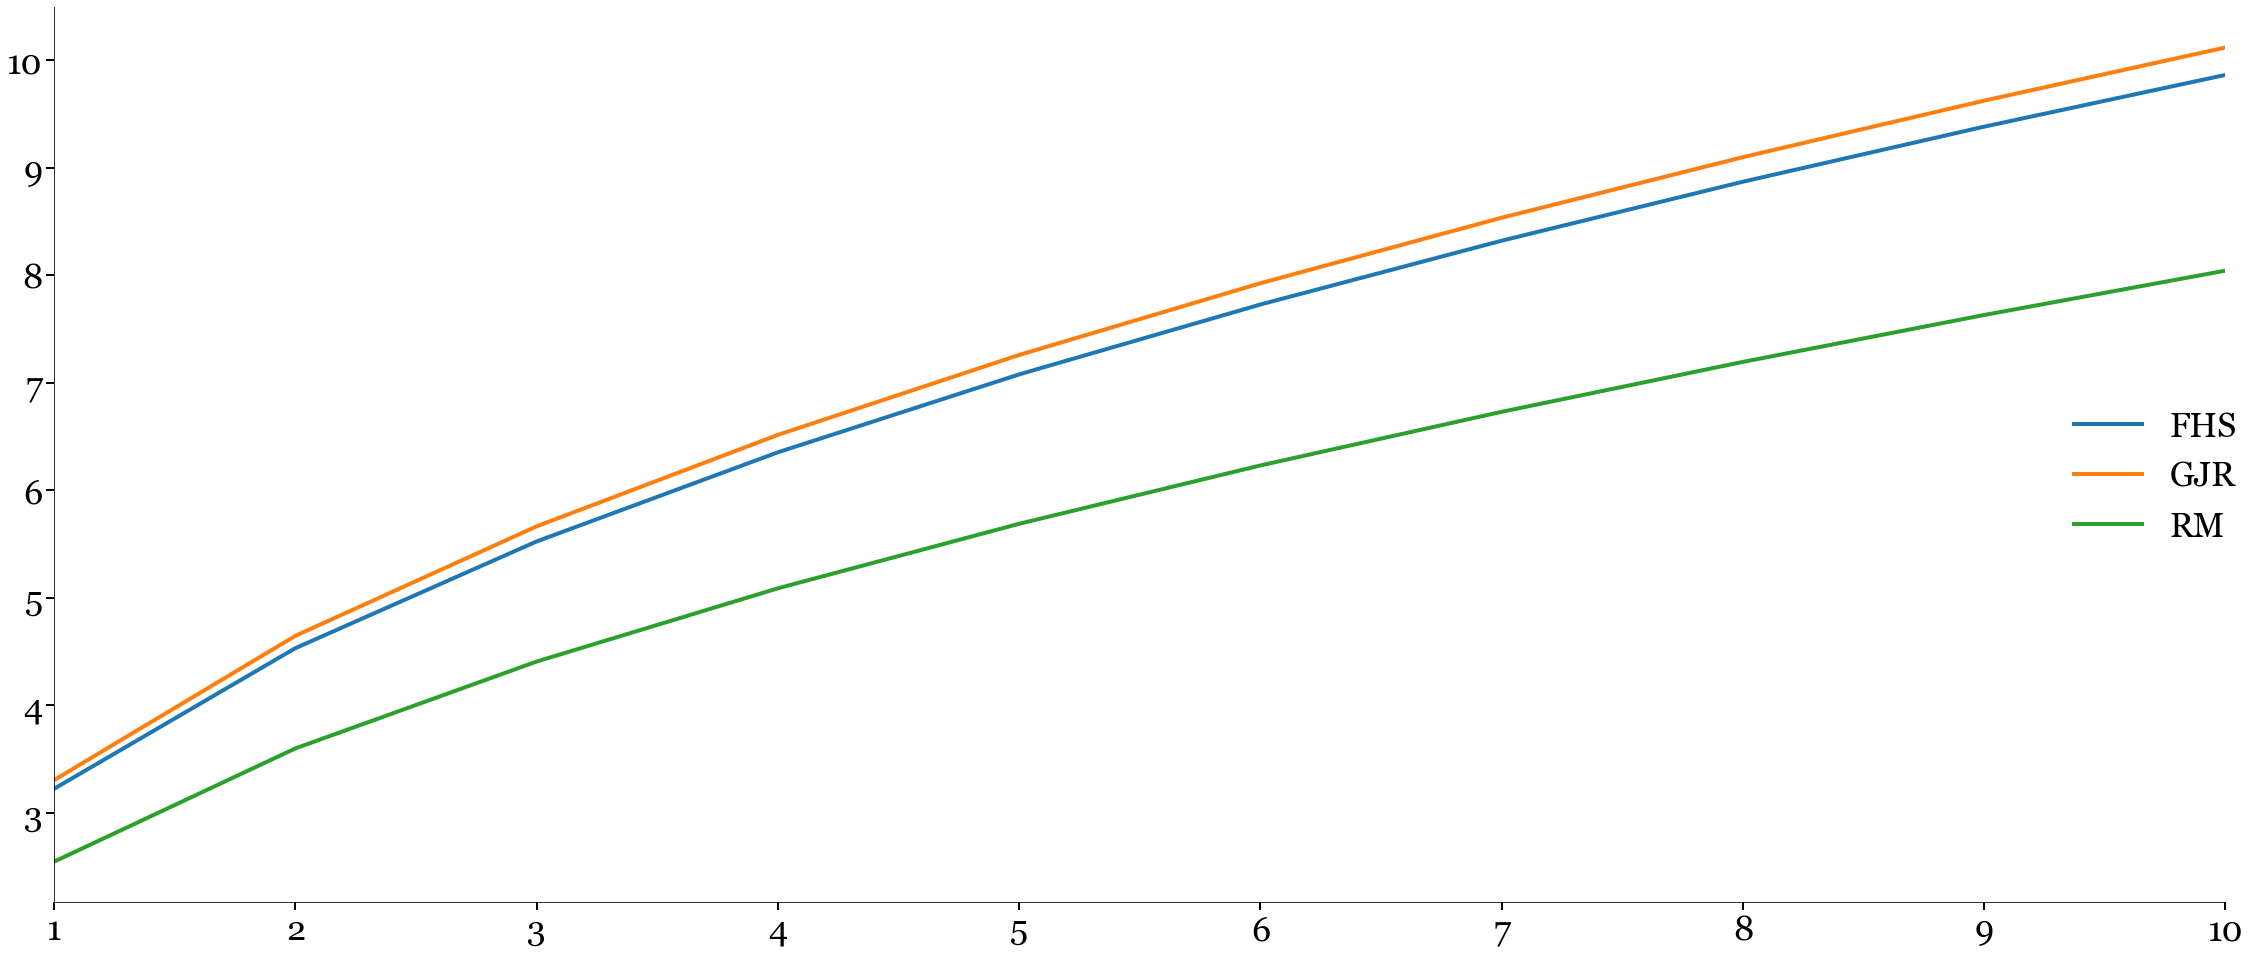

In [35]:
plot(df, loc=5)

# CaViaR

* Conditional quantile regression
* Uses ARCH-like dynamics
* Minimizes the _tick_ loss function

$$ \arg\min_{\theta}\,\,\,T^{-1}\sum_{t=1}^{T}\alpha(r_{t}-q_{t})(1-I_{[r_{t}<q_{t}]})+(1-\alpha)(q_{t}-r_{t})I_{[r_{t}<q_{t}]}$$

* $q_t$  is the conditional $\alpha$ quantile of $r_t$

# Tick Loss Function

In [36]:
def tick_loss(alpha=(0.05, 0.25, 0.5)):
    x = np.linspace(-3, 3, 121)
    values = {}
    for a in alpha:
        values[rf"$\alpha={a}$"] = (1 - a) * np.abs(x) * (x <= 0) + a * x * (x > 0)
    plot(pd.DataFrame(values, index=x))
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[1])
    ax.set_xlabel(r"$X-q_\alpha$")

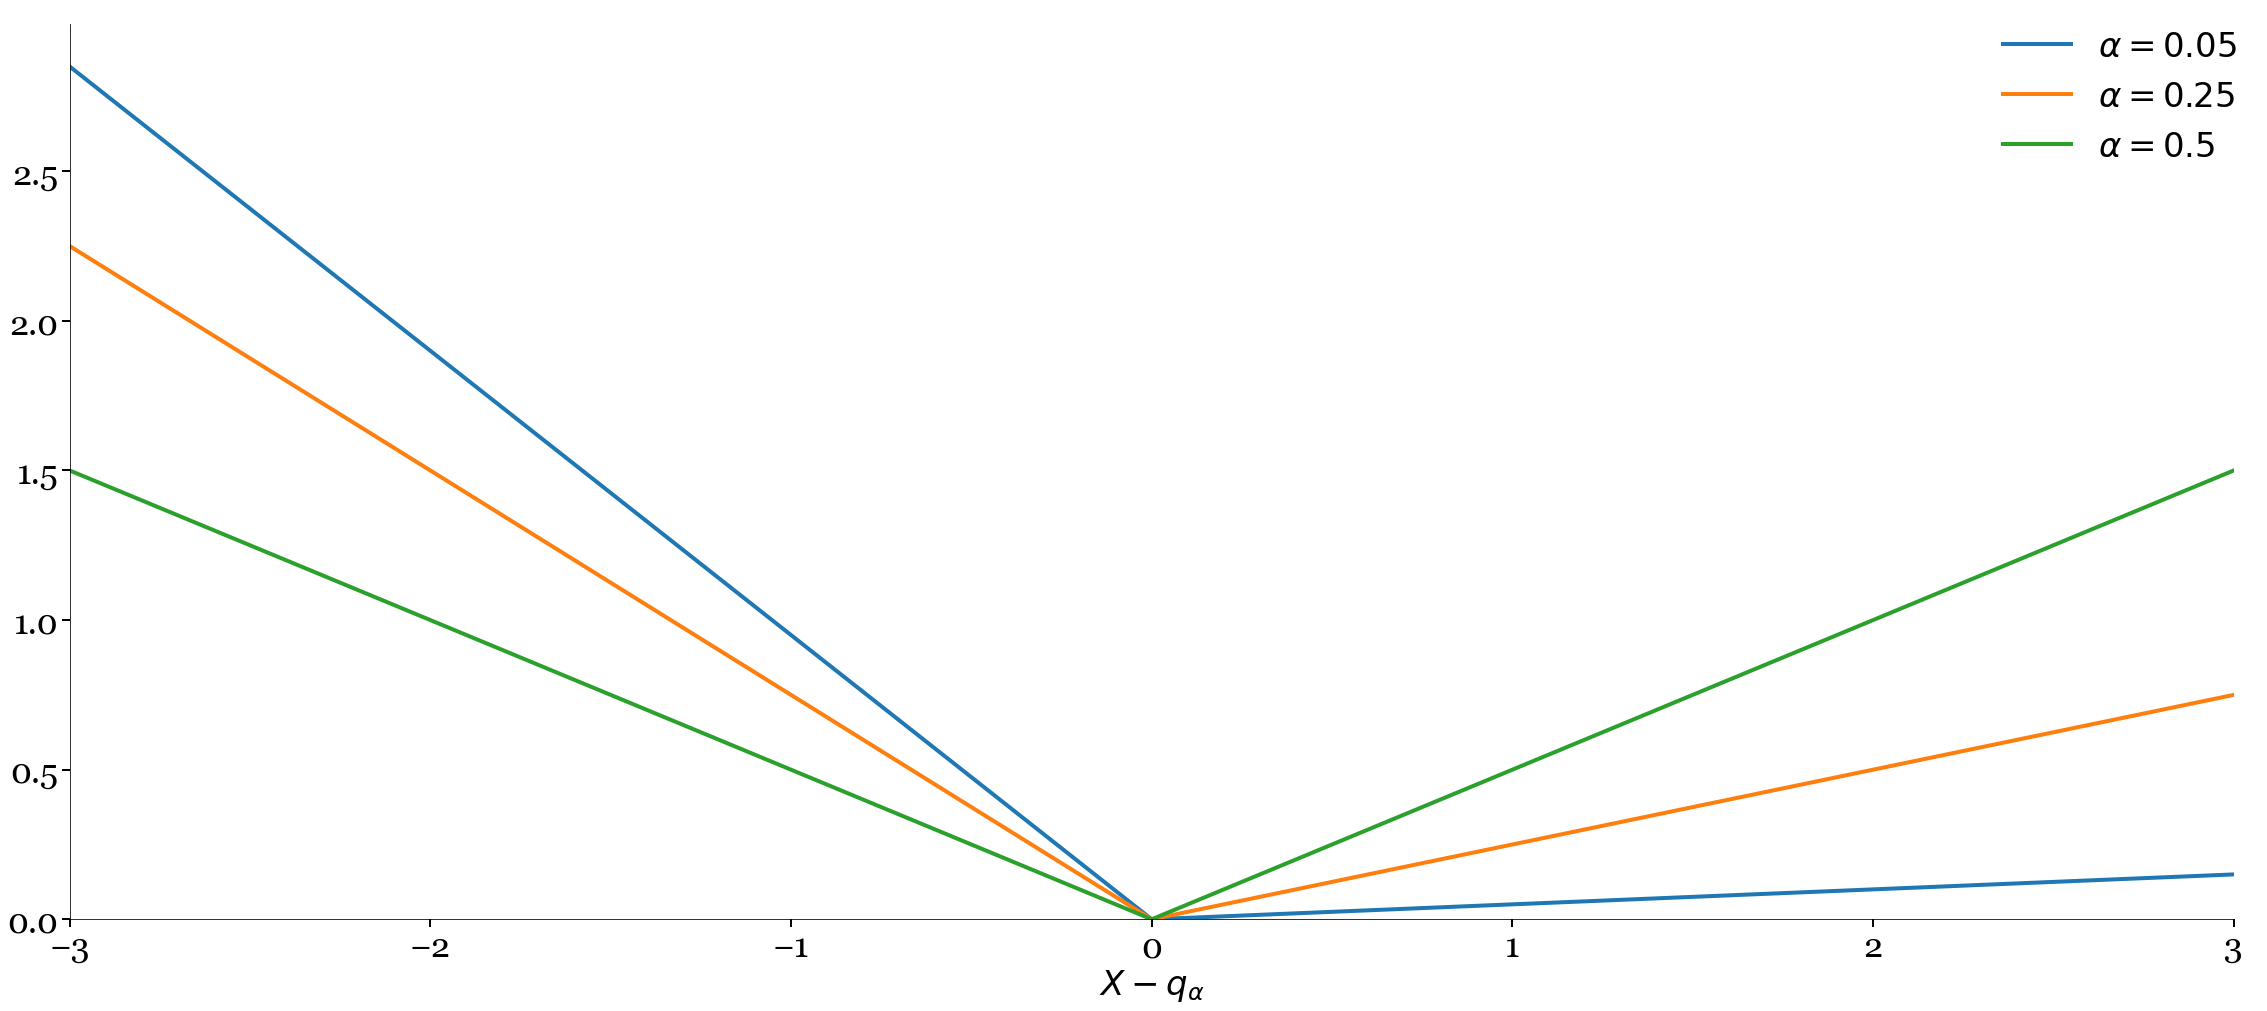

In [37]:
tick_loss()

# CaViar: Symmetric

* Quantiles evolove according to 

$$ q_{t+1}=\omega+\gamma\text{HIT}_{t}+\beta q_{t}$$

* A HIT is defined

$$ \text{HIT}_{t}=I_{[r_{t}<q_{t}]}-\alpha$$

* Mean-zero, white-noise shock under correct specification

In [38]:
import numpy as np

import caviar

rets = np.array(sp500)
opt = caviar.caviar(rets)
print(opt)
backcast = -np.quantile(rets, 0.05)
q = caviar.asym_abs_value(opt.x, backcast, rets, return_var=True)

1060.7718102606234
Optimization terminated successfully.
         Current function value: 1032.719684
         Iterations: 238
         Function evaluations: 398
 final_simplex: (array([[0.04626335, 0.03614533, 0.24121537, 0.90065074],
       [0.04625141, 0.03616817, 0.24114174, 0.9006613 ],
       [0.04625974, 0.036115  , 0.24122373, 0.90066053],
       [0.04625189, 0.0360939 , 0.24126851, 0.90066476],
       [0.04627052, 0.03618386, 0.24118521, 0.90063579]]), array([1032.7196837 , 1032.71968705, 1032.71970167, 1032.71970542,
       1032.71972328]))
           fun: 1032.7196836974836
       message: 'Optimization terminated successfully.'
          nfev: 398
           nit: 238
        status: 0
       success: True
             x: array([0.04626335, 0.03614533, 0.24121537, 0.90065074])


In [39]:
opt = caviar.caviar_hit(rets, disp=False)
pd.Series(opt.x, index=["omega", "alpha", "beta"])

omega    0.078519
alpha    0.206854
beta     0.945180
dtype: float64

In [40]:
params = opt.x
backcast = -np.quantile(rets, 0.05)
q = caviar.hit_caviar_core(params, backcast, rets)
s = pd.Series(q, index=sp500.index, name="CaViaR Quantile")

# Conditional Quantiles

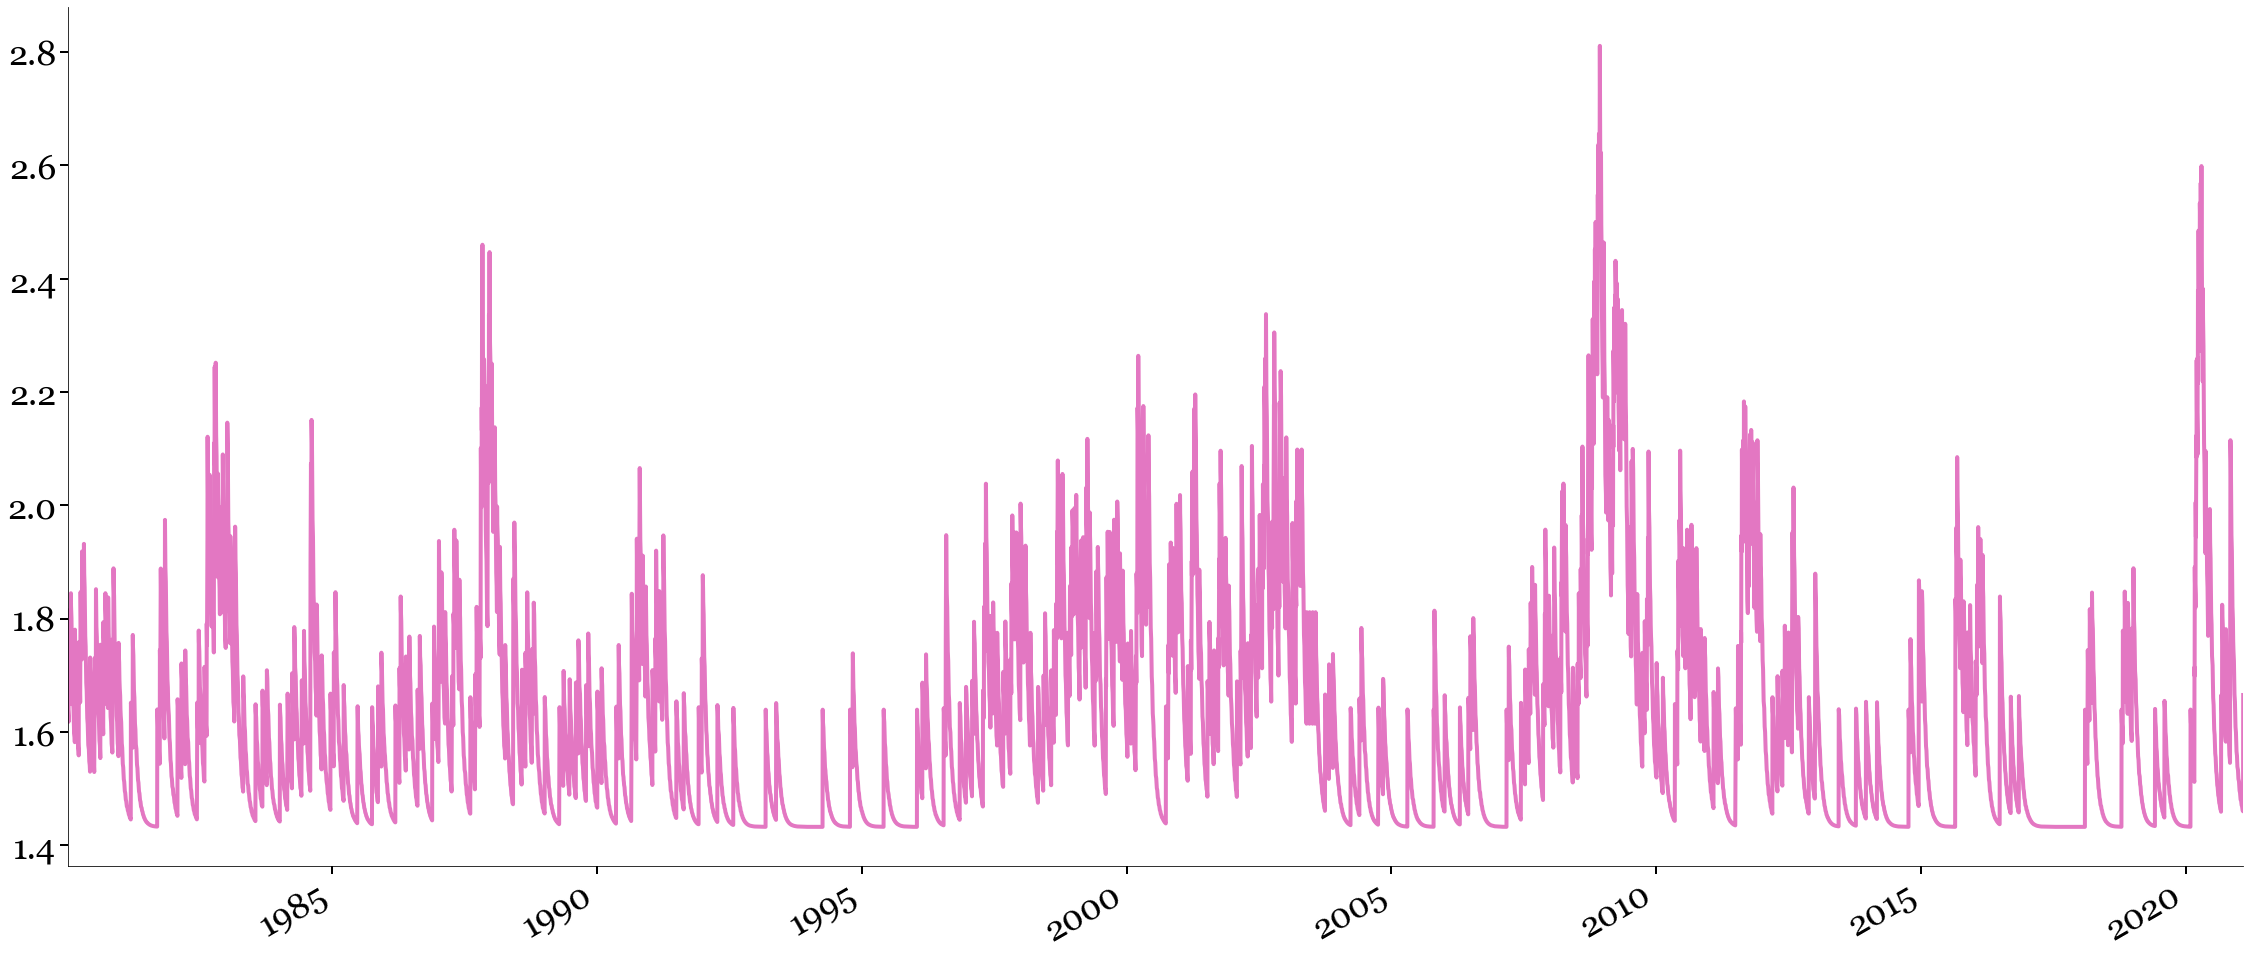

In [41]:
plot(s)

# Conditional Quantiles (past year)

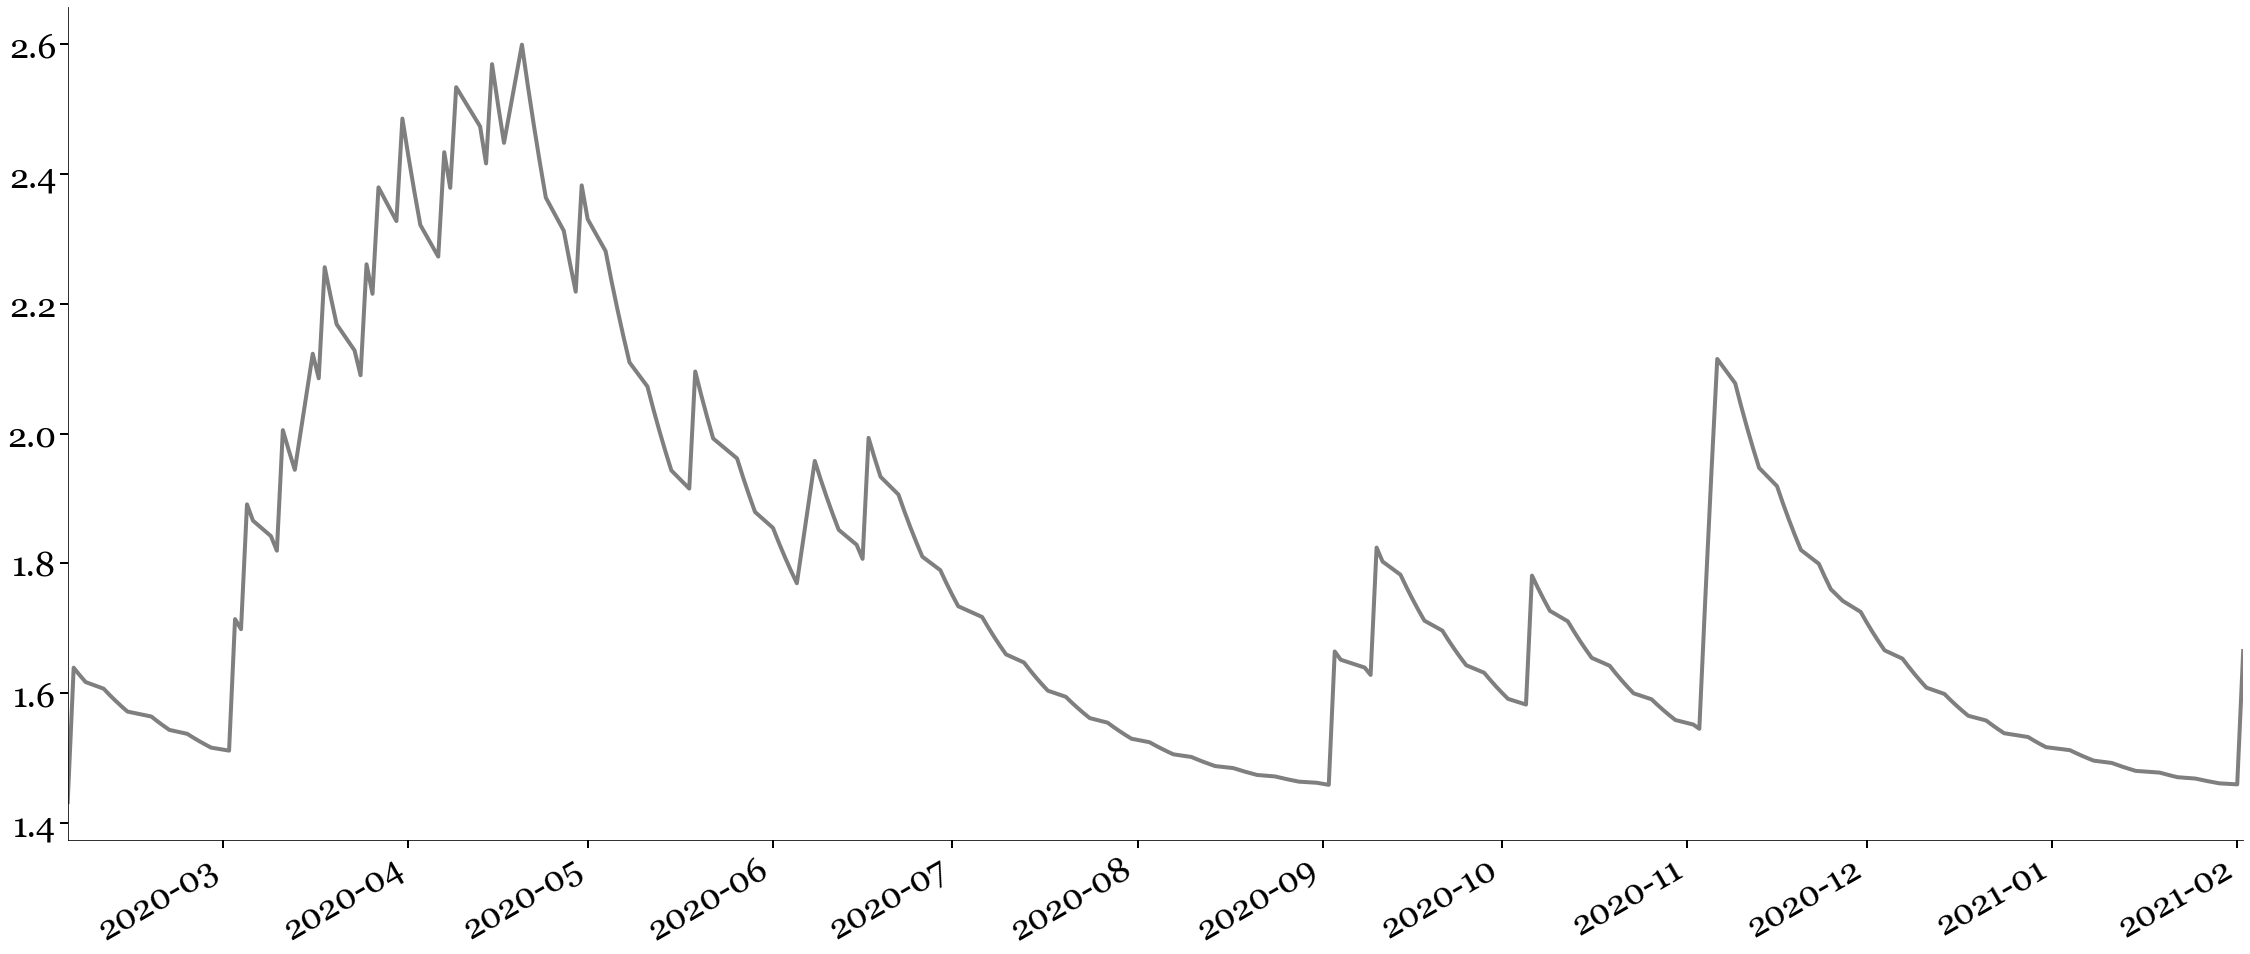

In [42]:
plot(s.iloc[-252:])

# CaViaR: Asymmetric absolute value

In [43]:
opt = caviar.caviar(np.array(rets))
asym_caviar_q = caviar.asym_abs_value_core(opt.x, backcast, rets)
asym_caviar_q = pd.Series(asym_caviar_q, index=sp500.index, name="Asym Abs Value")

1060.7718102606234
Optimization terminated successfully.
         Current function value: 1032.719684
         Iterations: 238
         Function evaluations: 398


In [44]:
pd.Series(opt.x, index=["omega", "alpha", "gamma", "beta"])

omega    0.046263
alpha    0.036145
gamma    0.241215
beta     0.900651
dtype: float64

# CaViaR: Asymmetric absolute value quantiles

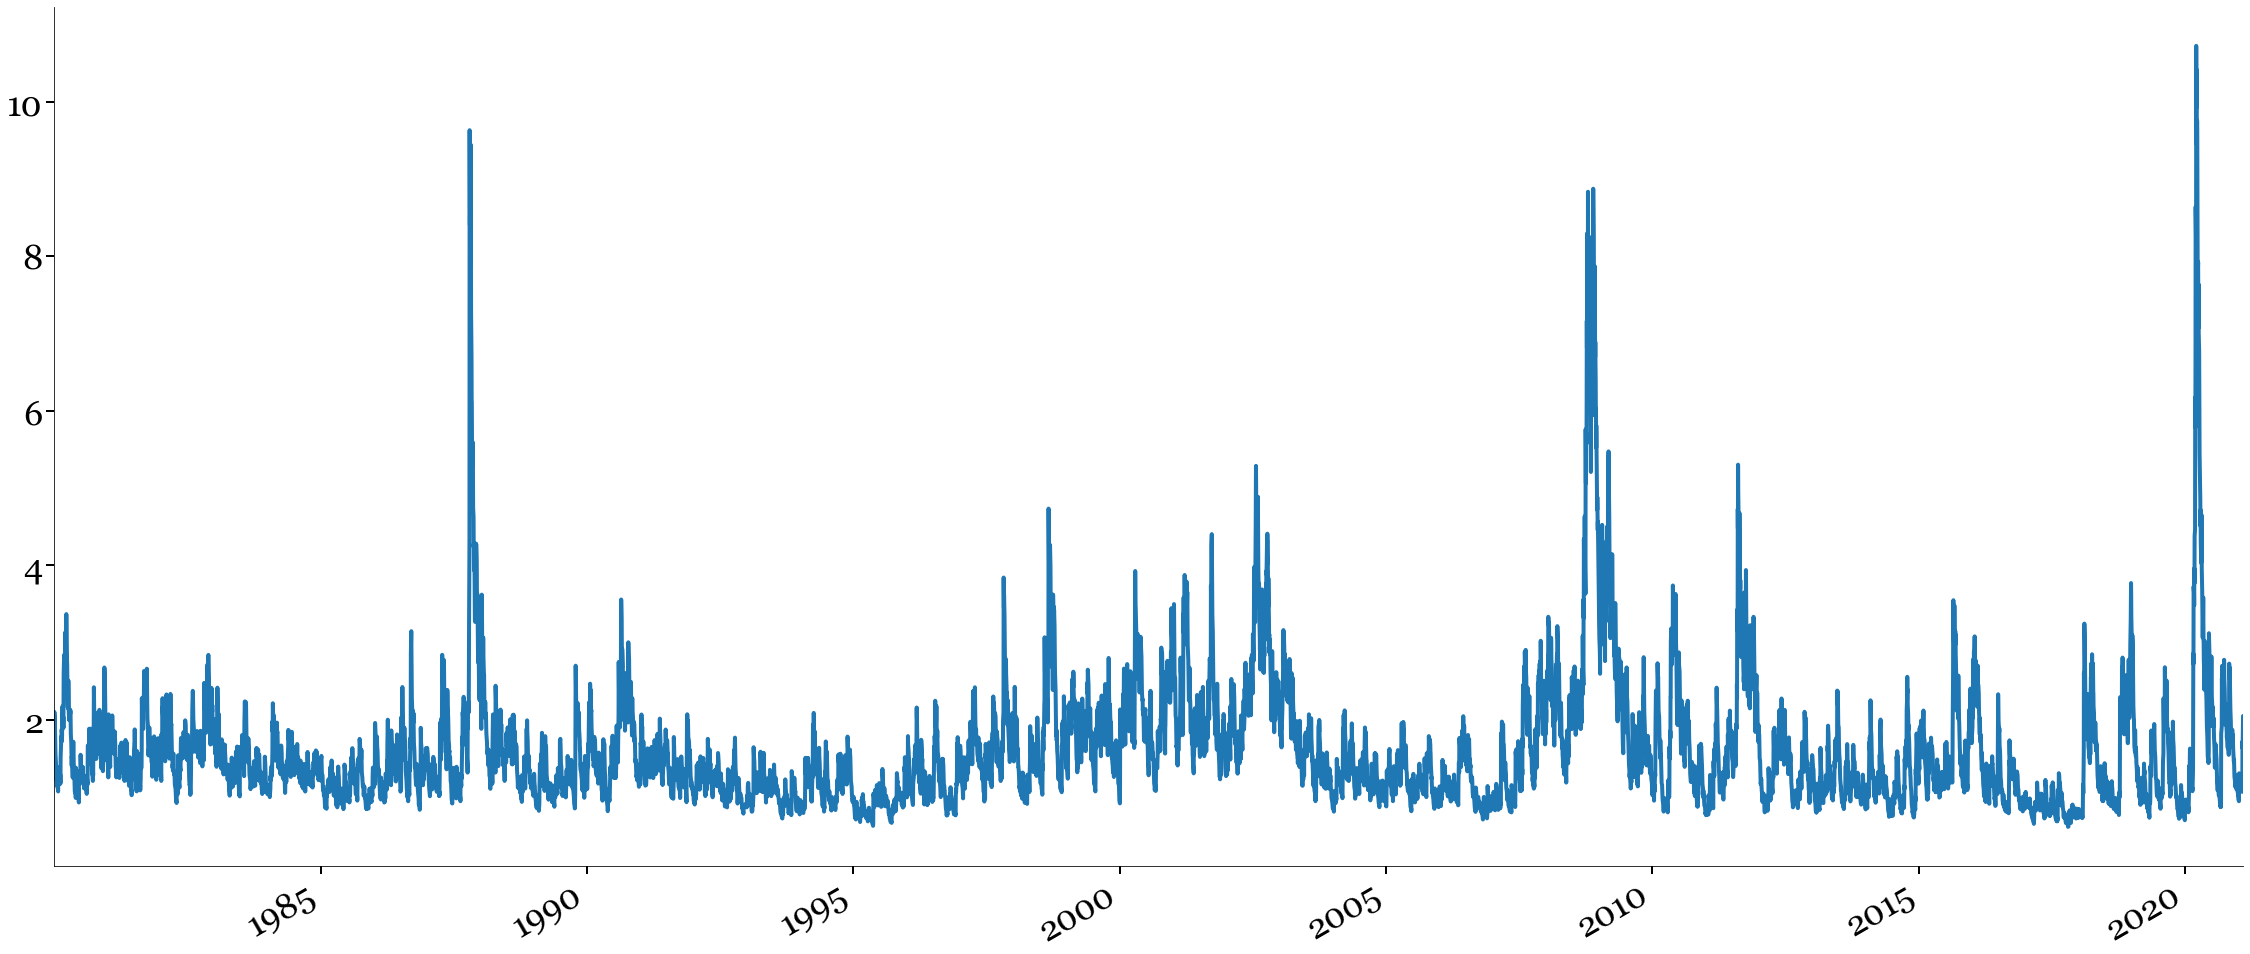

In [45]:
plot(asym_caviar_q)

# CaViaR: Asymmetric absolute value quantiles (last year)

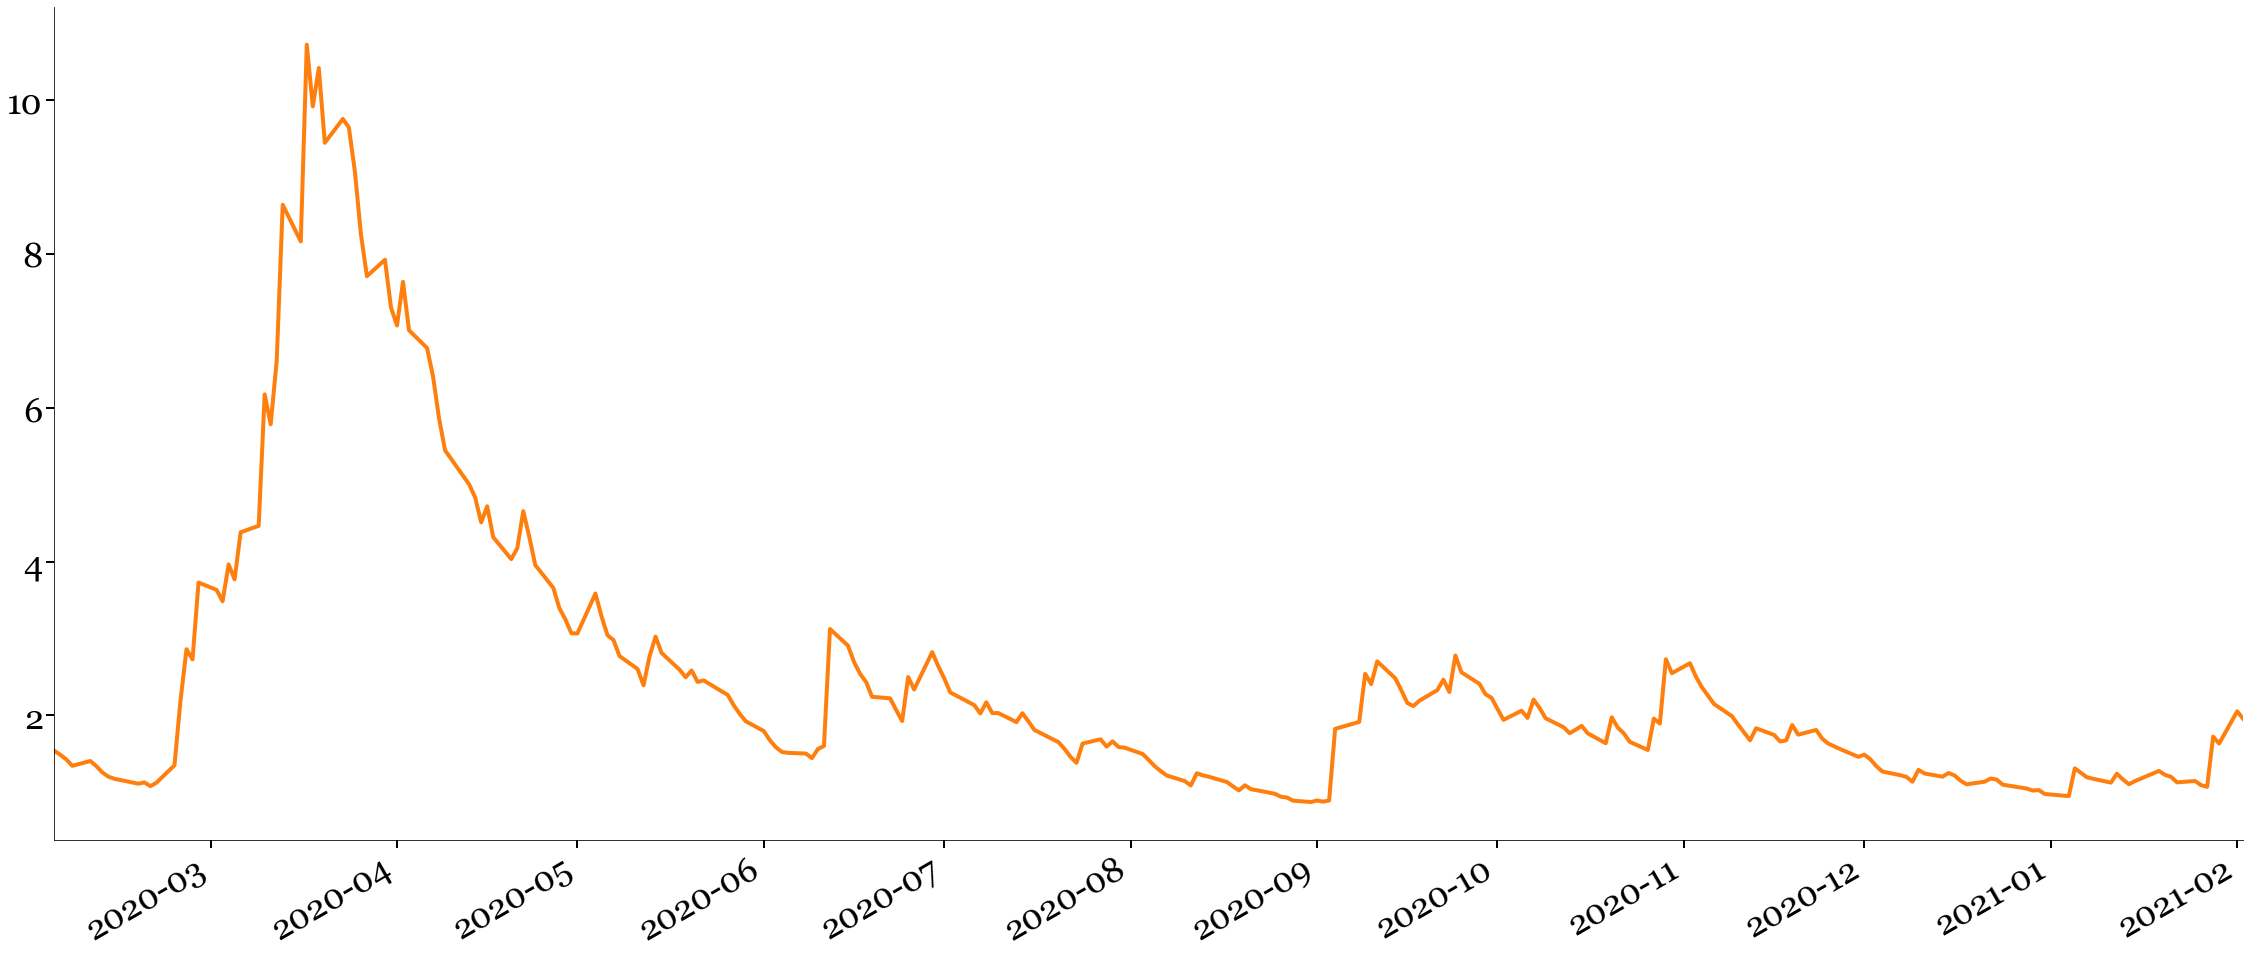

In [46]:
plot(asym_caviar_q.iloc[-252:])

In [47]:
tarch = arch_model(sp500, o=1, power=1.0, dist="t").fit(disp="off")
q = -tarch.model.distribution.ppf(0.05, tarch.params["nu"])
tarch_var = tarch.conditional_volatility * q
df = pd.concat([tarch_var, asym_caviar_q], 1)
df.columns = ["TARCH", "Asym CaViaR"]

# Comparing Asym Absolute Val CaViaR and Skew $t$ TARCH

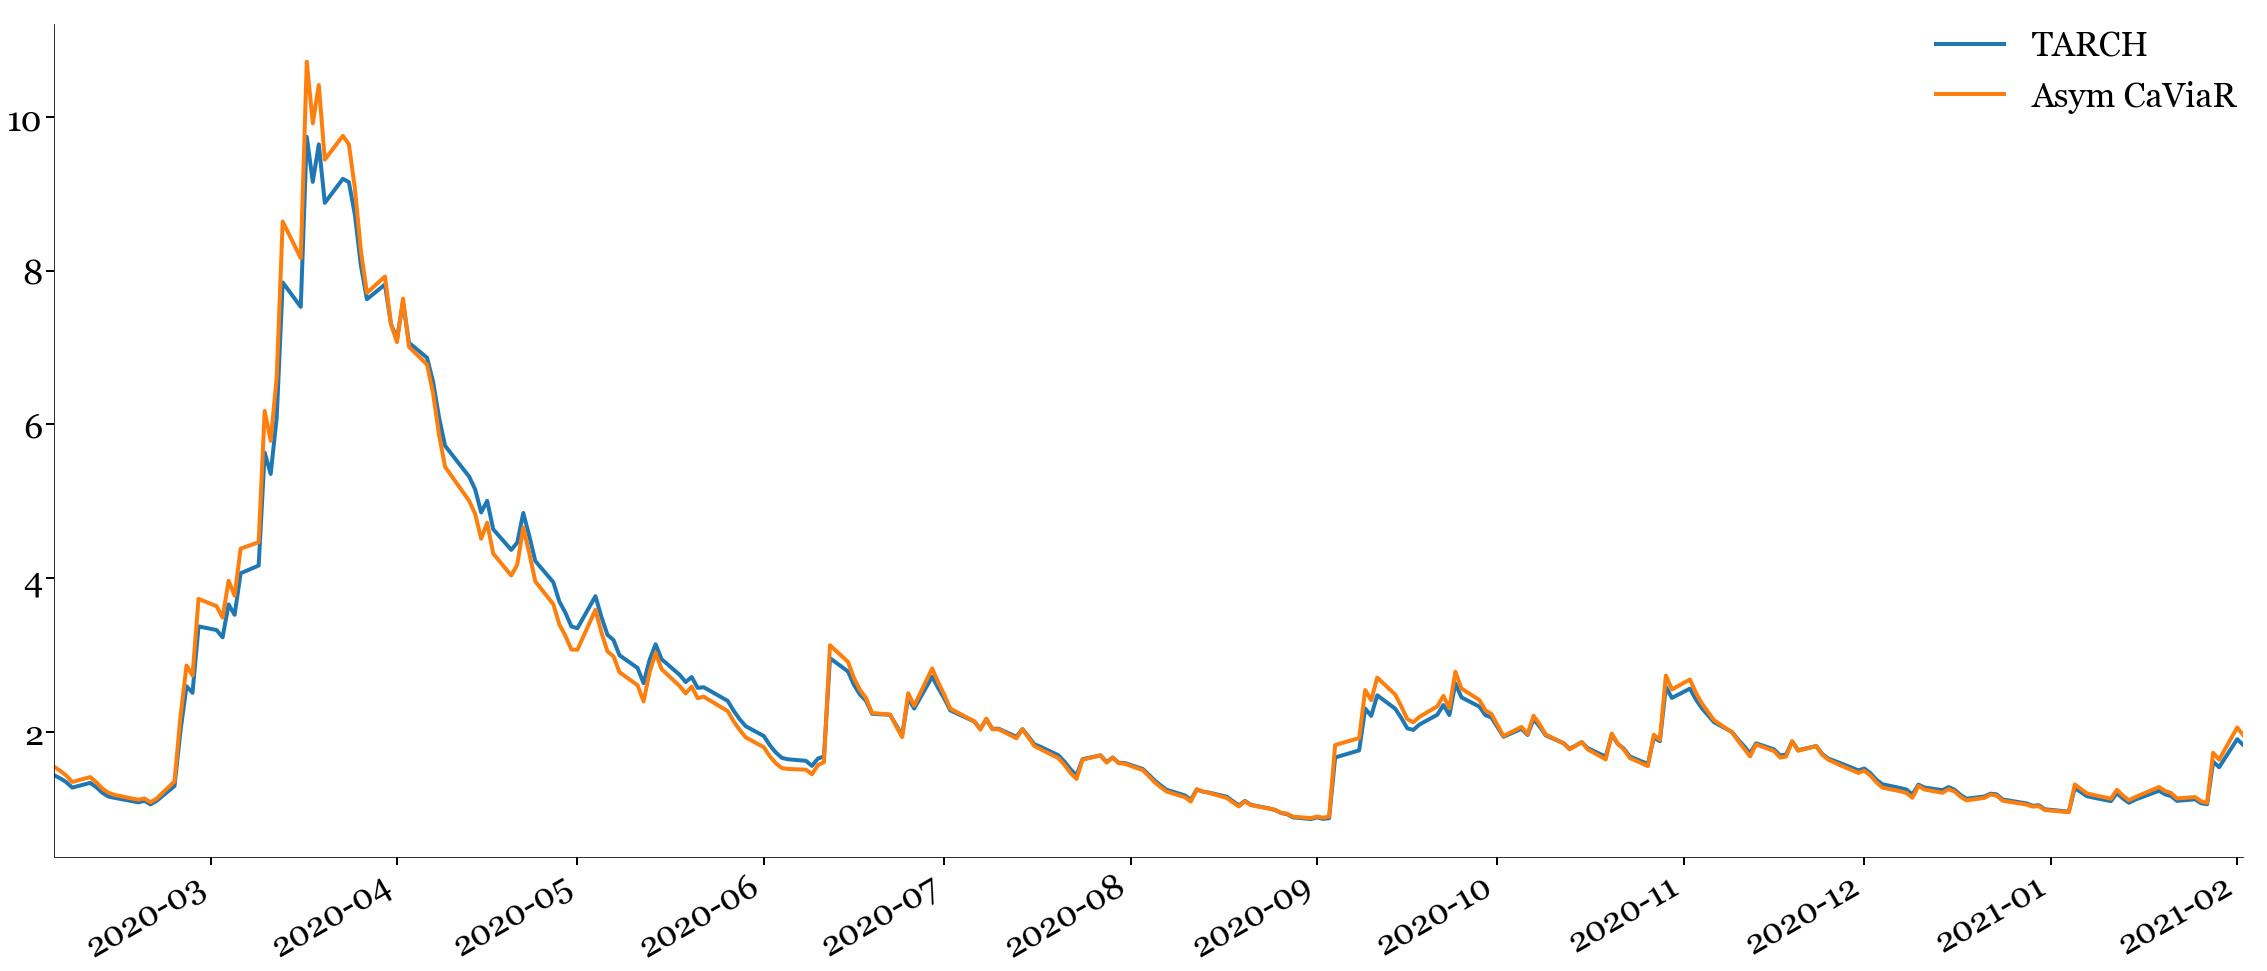

In [48]:
plot(df.iloc[-252:])

# Weighted Historical Simulation

$$w_{i}=\lambda^{t-i}\left(1-\lambda\right)/\left(1-\lambda^{t}\right)\,,\,\ i=1,2,\ldots,t$$

* Weighted Empirical cdf

$$\hat{G}_{t}(r)=\sum_{i=1}^{t}w_{i}I_{[r_{i}<r]}$$

* Conditional VaR is solution to

$$\textrm{VaR}_{t+1}=-\min_{r}\hat{G}(r)\geq\alpha$$


In [49]:
def single(x, lam, alpha):
    x = np.asarray(x)
    t = x.shape[0]
    w = lam ** np.arange(t)[::-1] * (1 - lam) / (1 - lam ** t)
    idx = np.argsort(x)
    cw = np.cumsum(w[idx])
    loc = np.amin(np.argwhere(cw > alpha))
    return x[idx][loc]


def whs(s, alpha, lam=0.9, window=252):
    t = s.shape[0]
    out = {}
    for i in range(window, t):
        out[s.index[i]] = single(s.iloc[i - window : i], lam, alpha)
    out_s = pd.Series(out)
    return -out_s.reindex(s.index)


df_data = {}
for lam in (0.9, 0.95, 0.975, 0.999):
    df_data[rf"$\lambda={lam}$"] = whs(sp500, 0.05, lam=lam)
df = pd.DataFrame(df_data).dropna()

In [50]:
def plot_wecdf(x, lam, unweighted=False):
    t = x.shape[0]
    w = lam ** np.arange(t)[::-1] * (1 - lam) / (1 - lam ** t)
    idx = np.argsort(x)
    cw = np.cumsum(w[idx])
    loc = np.amin(np.argwhere(cw > alpha))
    x = x.iloc[idx]
    w = w[idx]
    data = []
    cdf = 0.0
    for i in range(x.shape[0]):
        data.append([x.iloc[i], cdf])
        if i < x.shape[0] - 1:
            data.append([x.iloc[i + 1], cdf])
        cdf += w[i]
    cdf_data = pd.DataFrame(data, columns=["S\&P 500", "Weighted Empirical cdf"])
    if unweighted:
        w[:] = 1/t
        data = []
        cdf = 0.0
        for i in range(x.shape[0]):
            data.append([x.iloc[i], cdf])
            if i < x.shape[0] - 1:
                data.append([x.iloc[i + 1], cdf])
            cdf += w[i]
        temp = pd.DataFrame(data, columns=["S\&P 500", "Empirical cdf"])
        temp = temp.set_index("S\&P 500")
        cdf_data["Empirical cdf"] = temp.iloc[:,0].to_numpy()
    
    plot(cdf_data.set_index("S\&P 500"), loc=5)
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[1])


# Weighted ECDF at start of COVID Pandemic

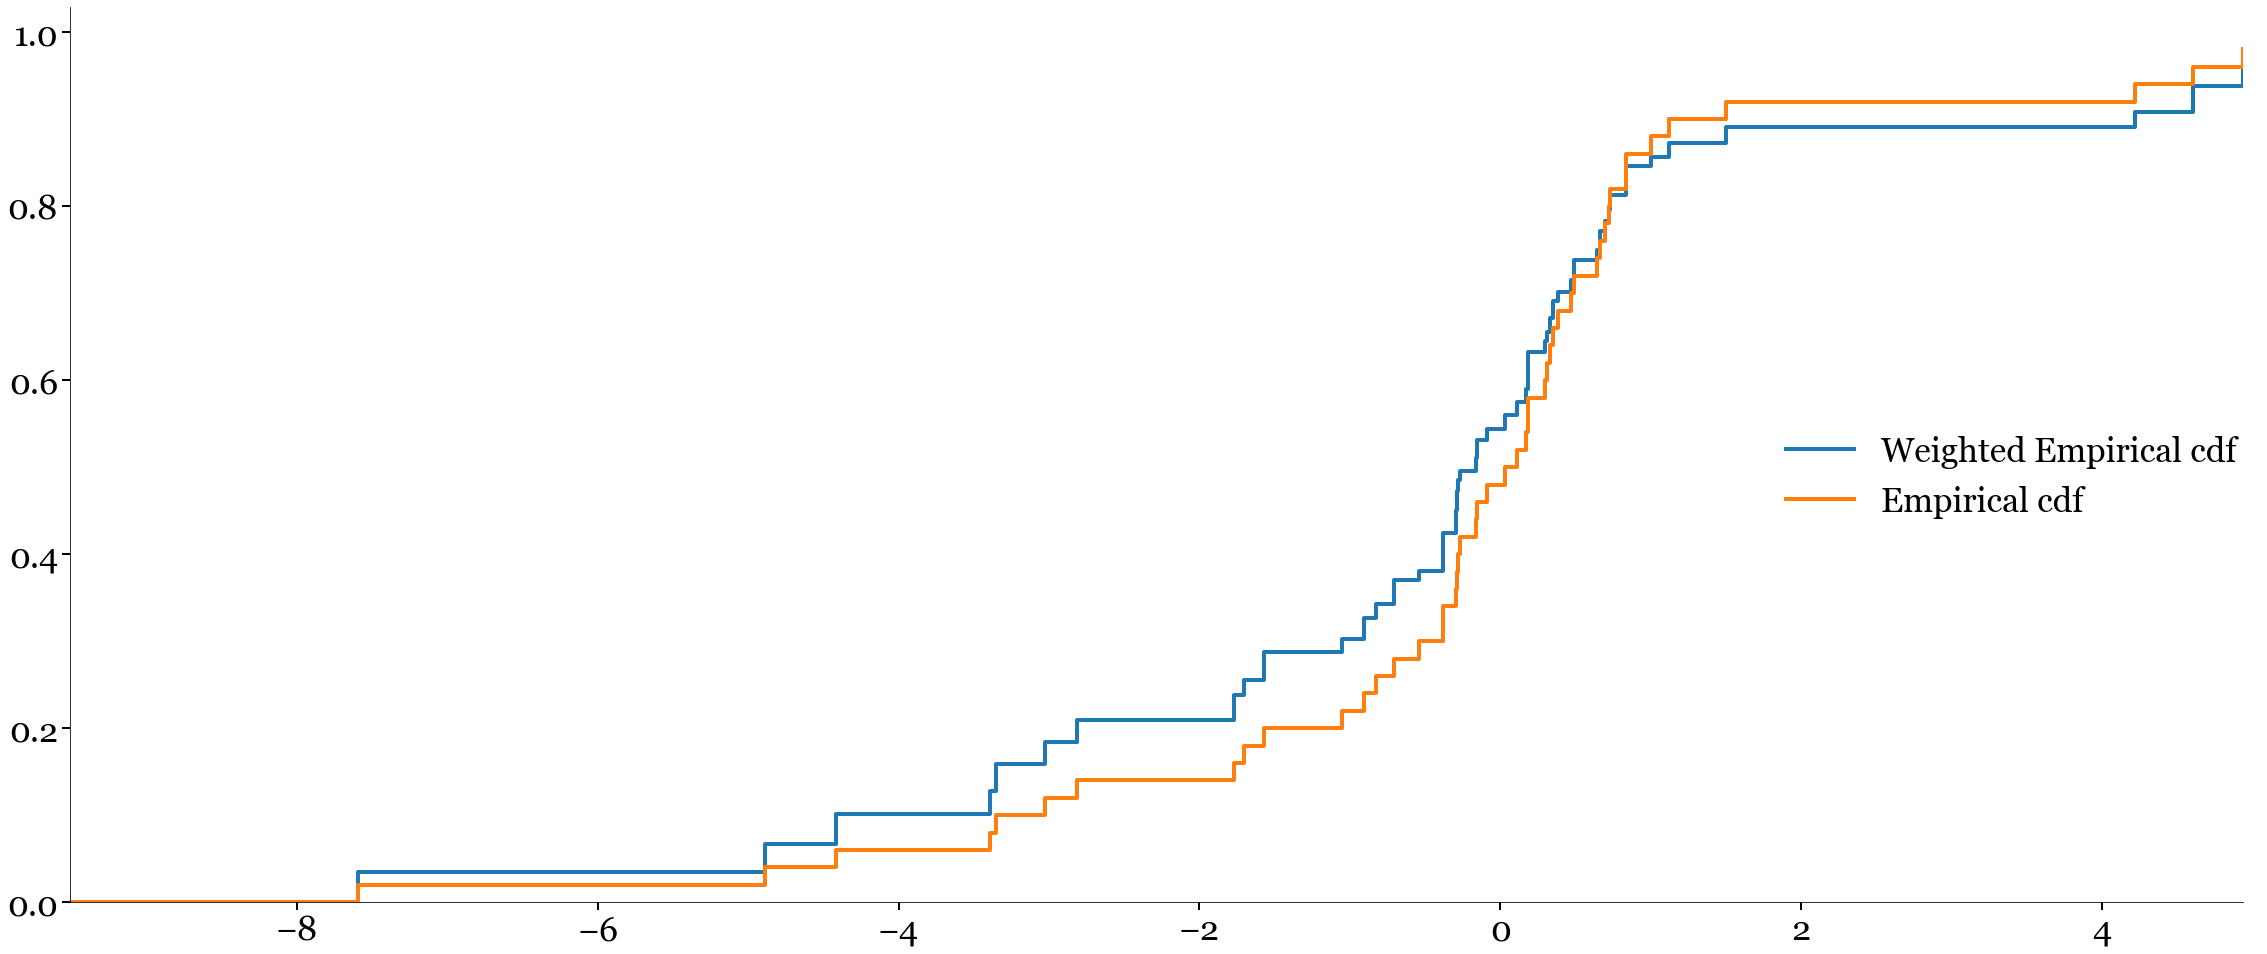

In [51]:
plot_wecdf(sp500.iloc[-275:-225], 0.975, True)

# Weighted ECDF before start of COVID Pandemic

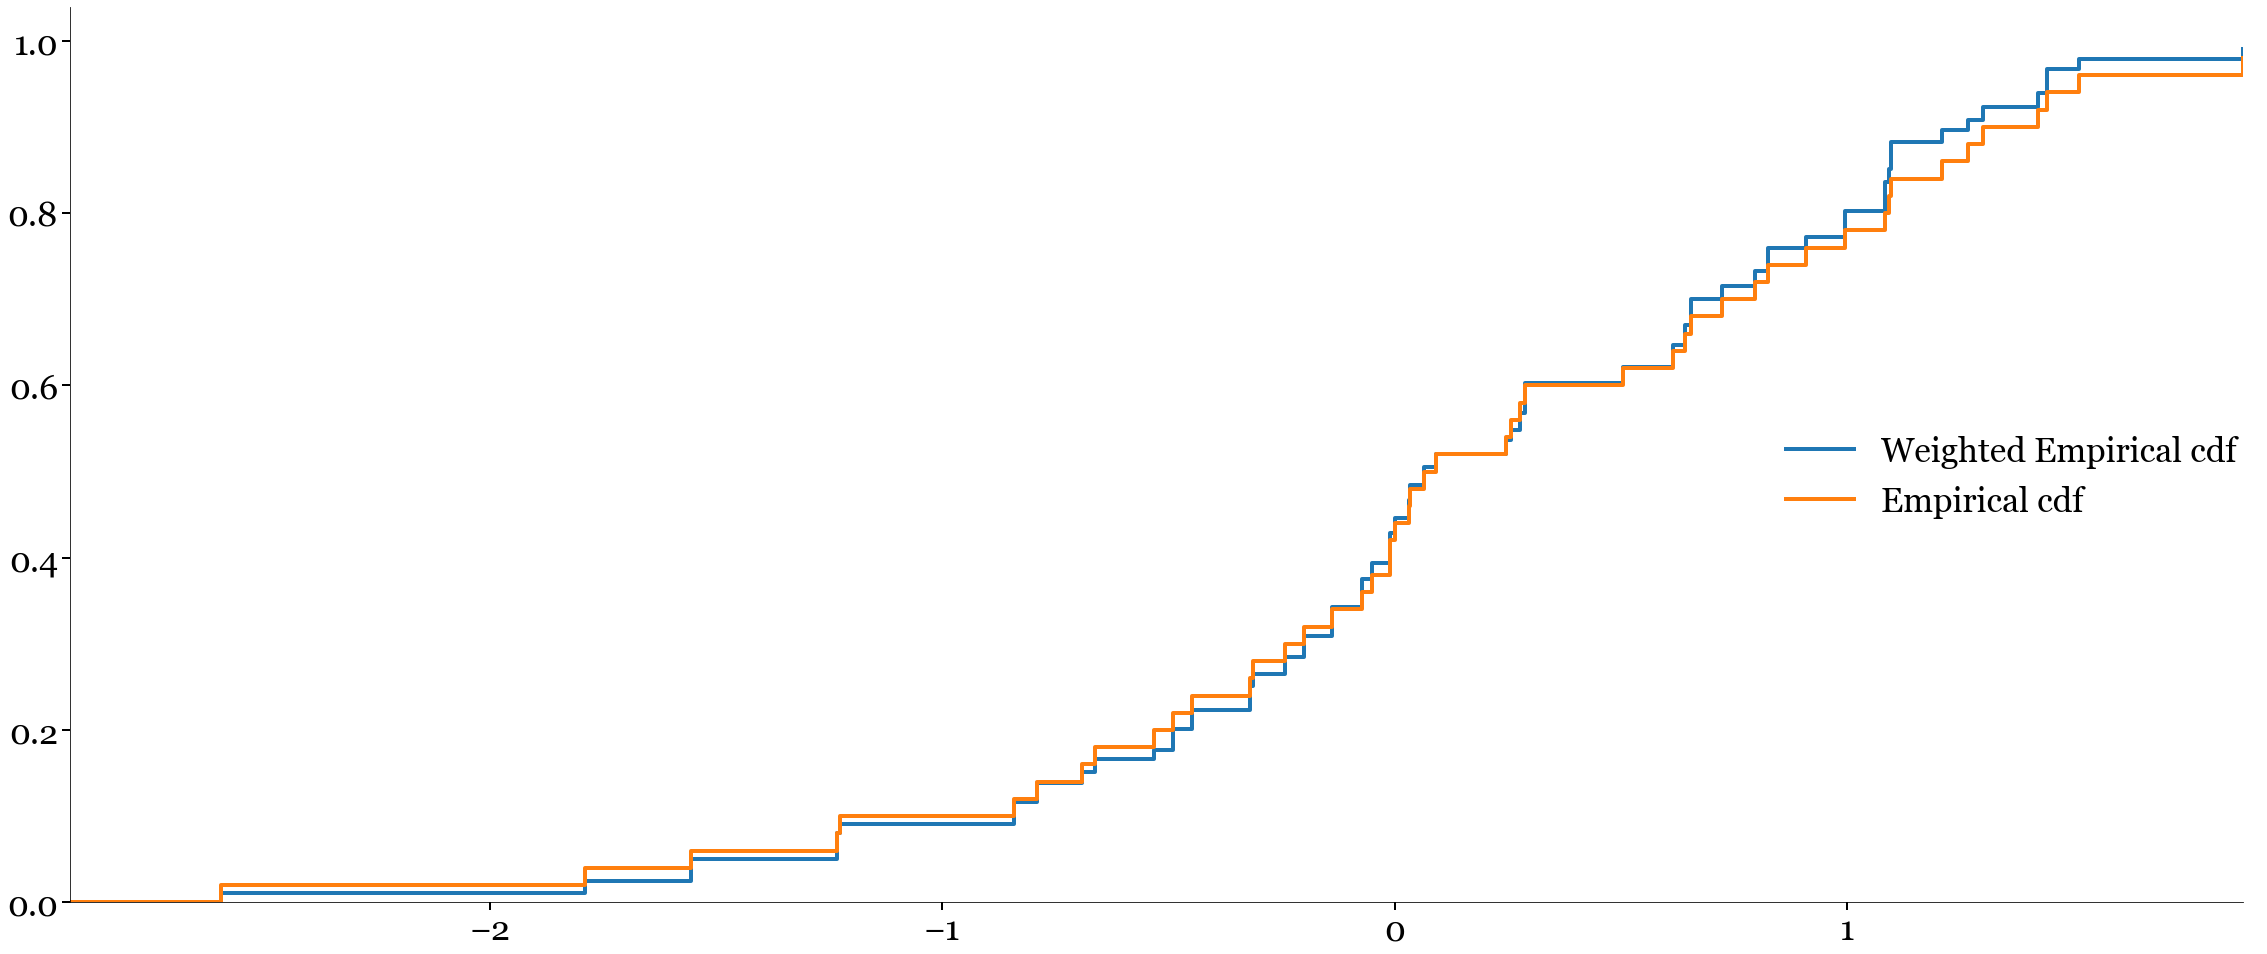

In [52]:
plot_wecdf(sp500.iloc[-375:-325], 0.975, True)

# Weighted HS

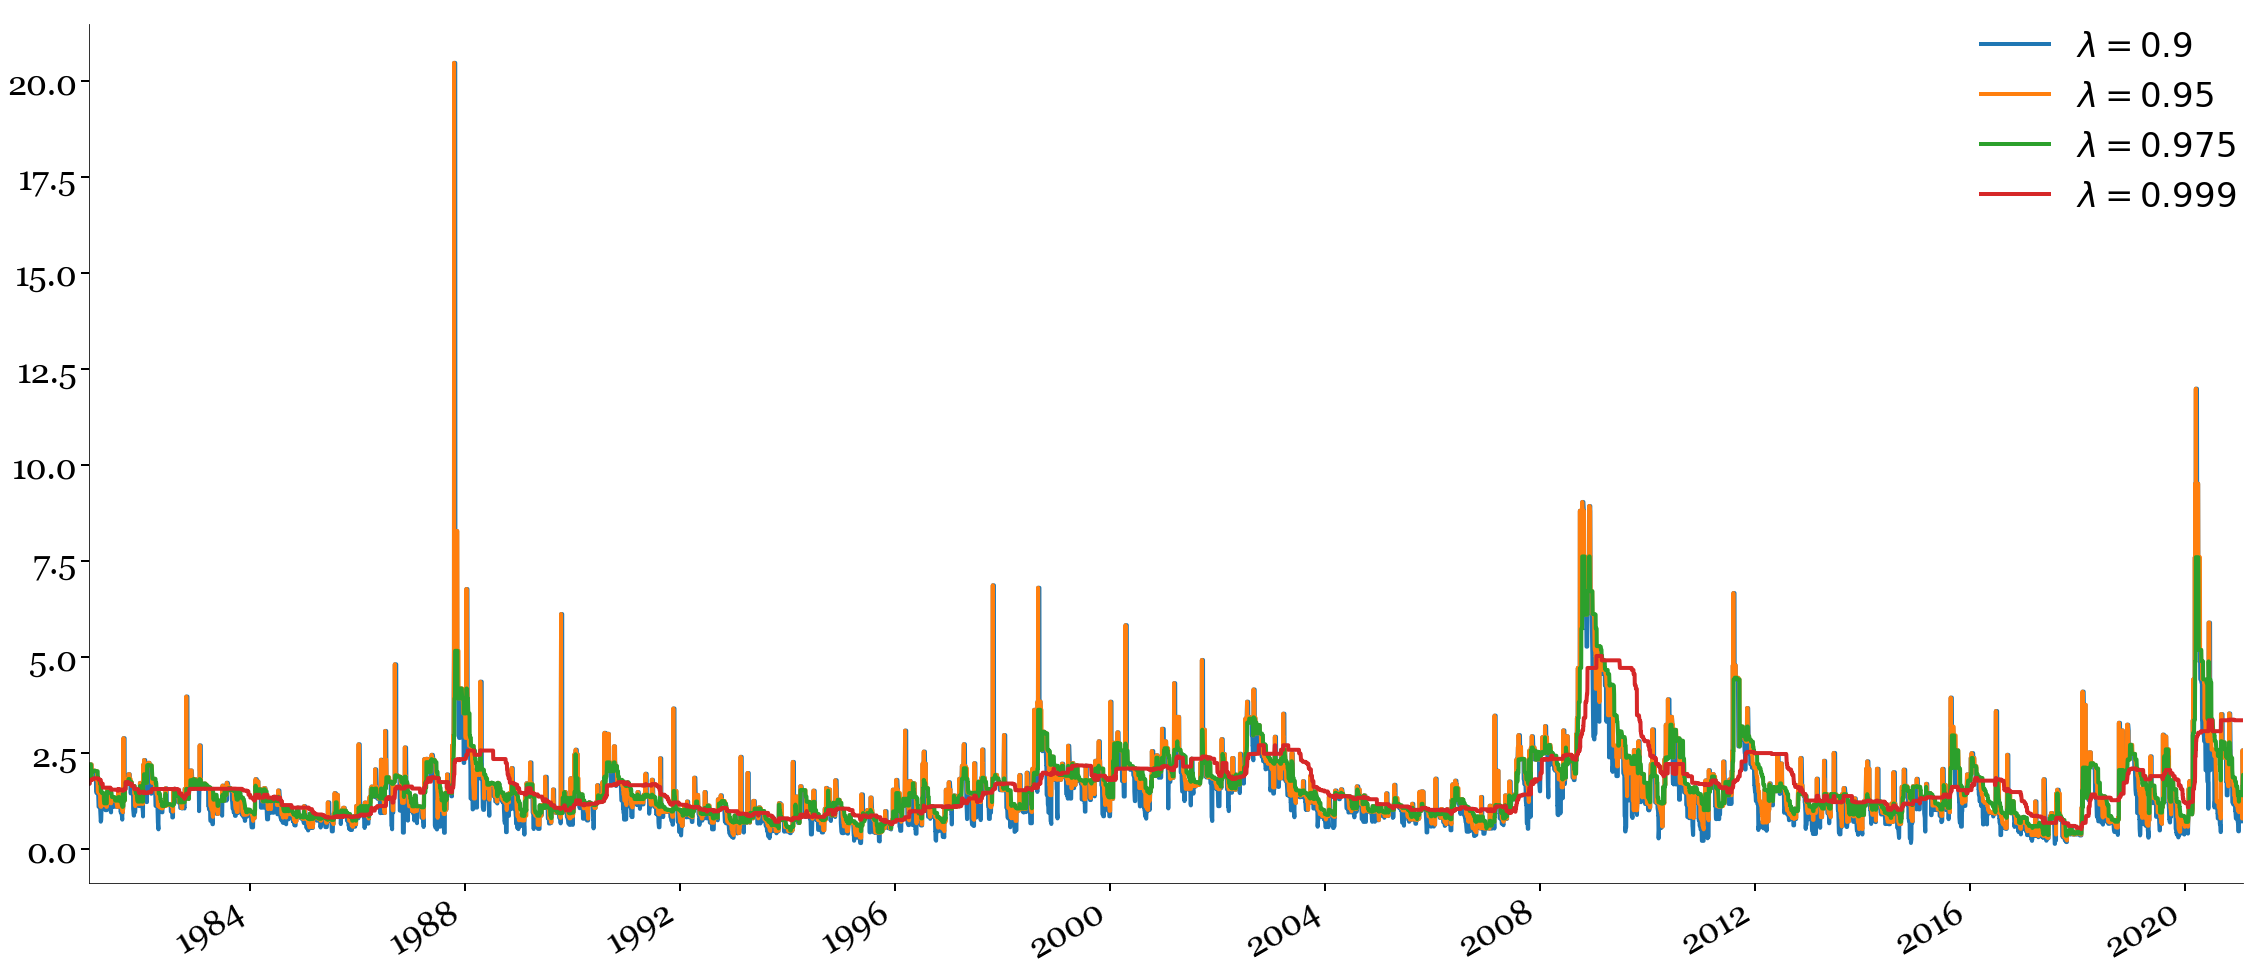

In [53]:
plot(df)

# Weighted HS (last year)

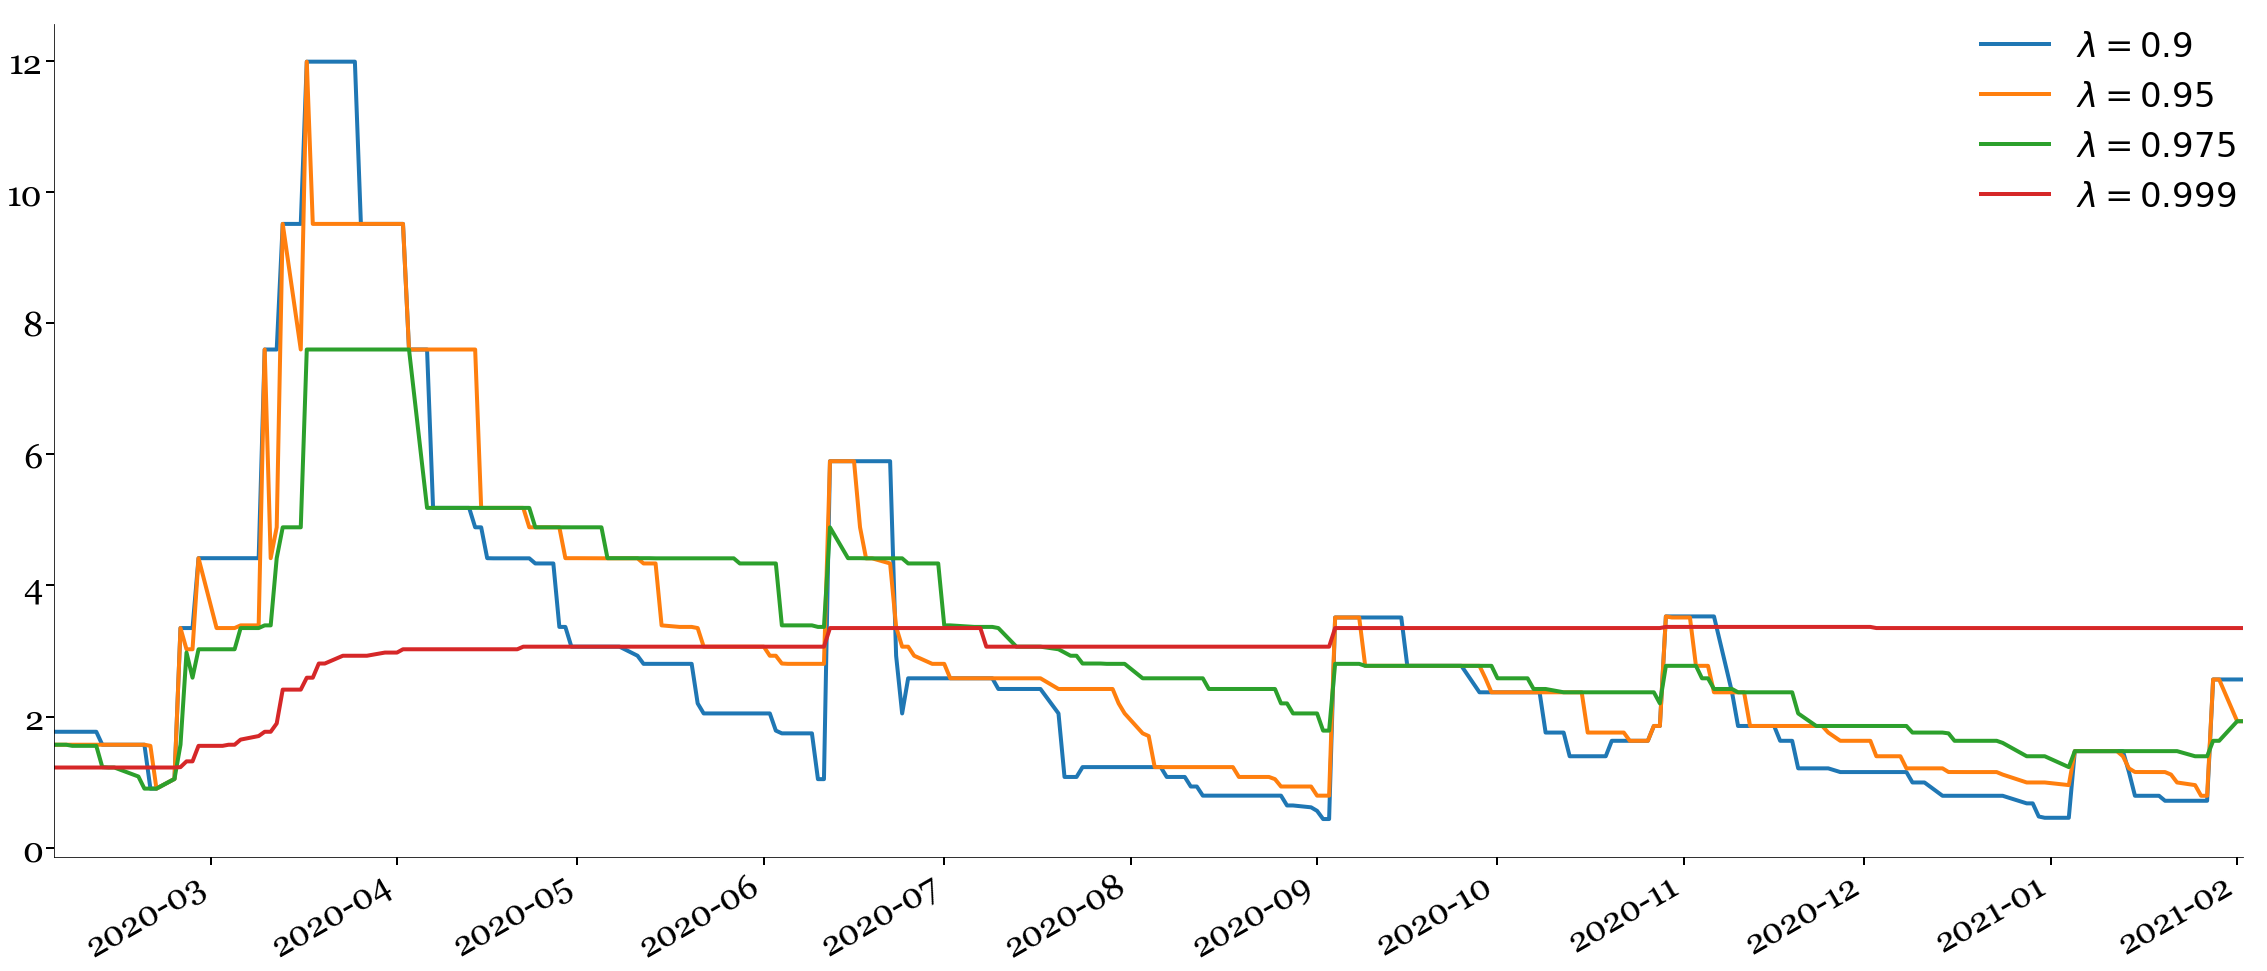

In [54]:
plot(df.iloc[-252:])

# Evaluation of Value-at-Risk Models

* Generalized Mincer-Zarnowitz
$$\text{HIT}_{t+h}=\gamma_{0}+\gamma_{1}VaR_{t+h|t}+\gamma_{2}\text{HIT}_{t}+\gamma_{3}\text{HIT}_{t-1}+\ldots+\gamma_{K}\text{HIT}_{t-K+1}+\eta_t$$
* Bernoulli
$$ I_{[r_t<q_t]} \sim \text{Bernoulli}(\alpha)$$
* Christoffersen's Conditional Bernoulli Test
$$ \left. I_{[r_t<q_t]} \right| r_{t-1},q_{t-1} \sim \text{Bernoulli}(\alpha)$$
* Logit/Probit improvement of GMZ
$$ \left. I_{[r_t<q_t]}  \right| \mathcal{F}_{t-1} \sim \text{Bernoulli}(\alpha)$$

In [55]:
# * Daily, Weekly
# * 1%, 5%
# * 50-50 split
# * RM, GJR-GARCH, WHS
alpha = 0.025
sp500_weekly = (
    100 * (1 + sp500 / 100.0).cumprod().resample("W").last().pct_change().dropna()
)
rm = ZeroMean(sp500_weekly, volatility=EWMAVariance(0.97)).fit()
rm_var = -rm.conditional_volatility * stats.norm.ppf(alpha)
t = sp500_weekly.shape[0]
last = sp500_weekly.index[t // 2]
gjr_weekly = arch_model(sp500_weekly, o=1, dist="skewt").fit(disp="off", last_obs=last)
vol = np.sqrt(gjr_weekly.forecast(start=last, align="target").variance)
gjr_q = gjr_weekly.model.distribution.ppf(alpha, gjr_weekly.params.iloc[-2:])
gjr_weekly_var = -vol * gjr_q
gjr_weekly_var = gjr_weekly_var.dropna()
weighted_hs_var = whs(sp500_weekly, alpha, lam=0.975, window=52).dropna()
weekly_vars = pd.concat([rm_var, gjr_weekly_var, weighted_hs_var], 1).dropna()
weekly_vars.columns = ["RM", "GJR", "WHS"]

# Weekly VaRs for S&P 500

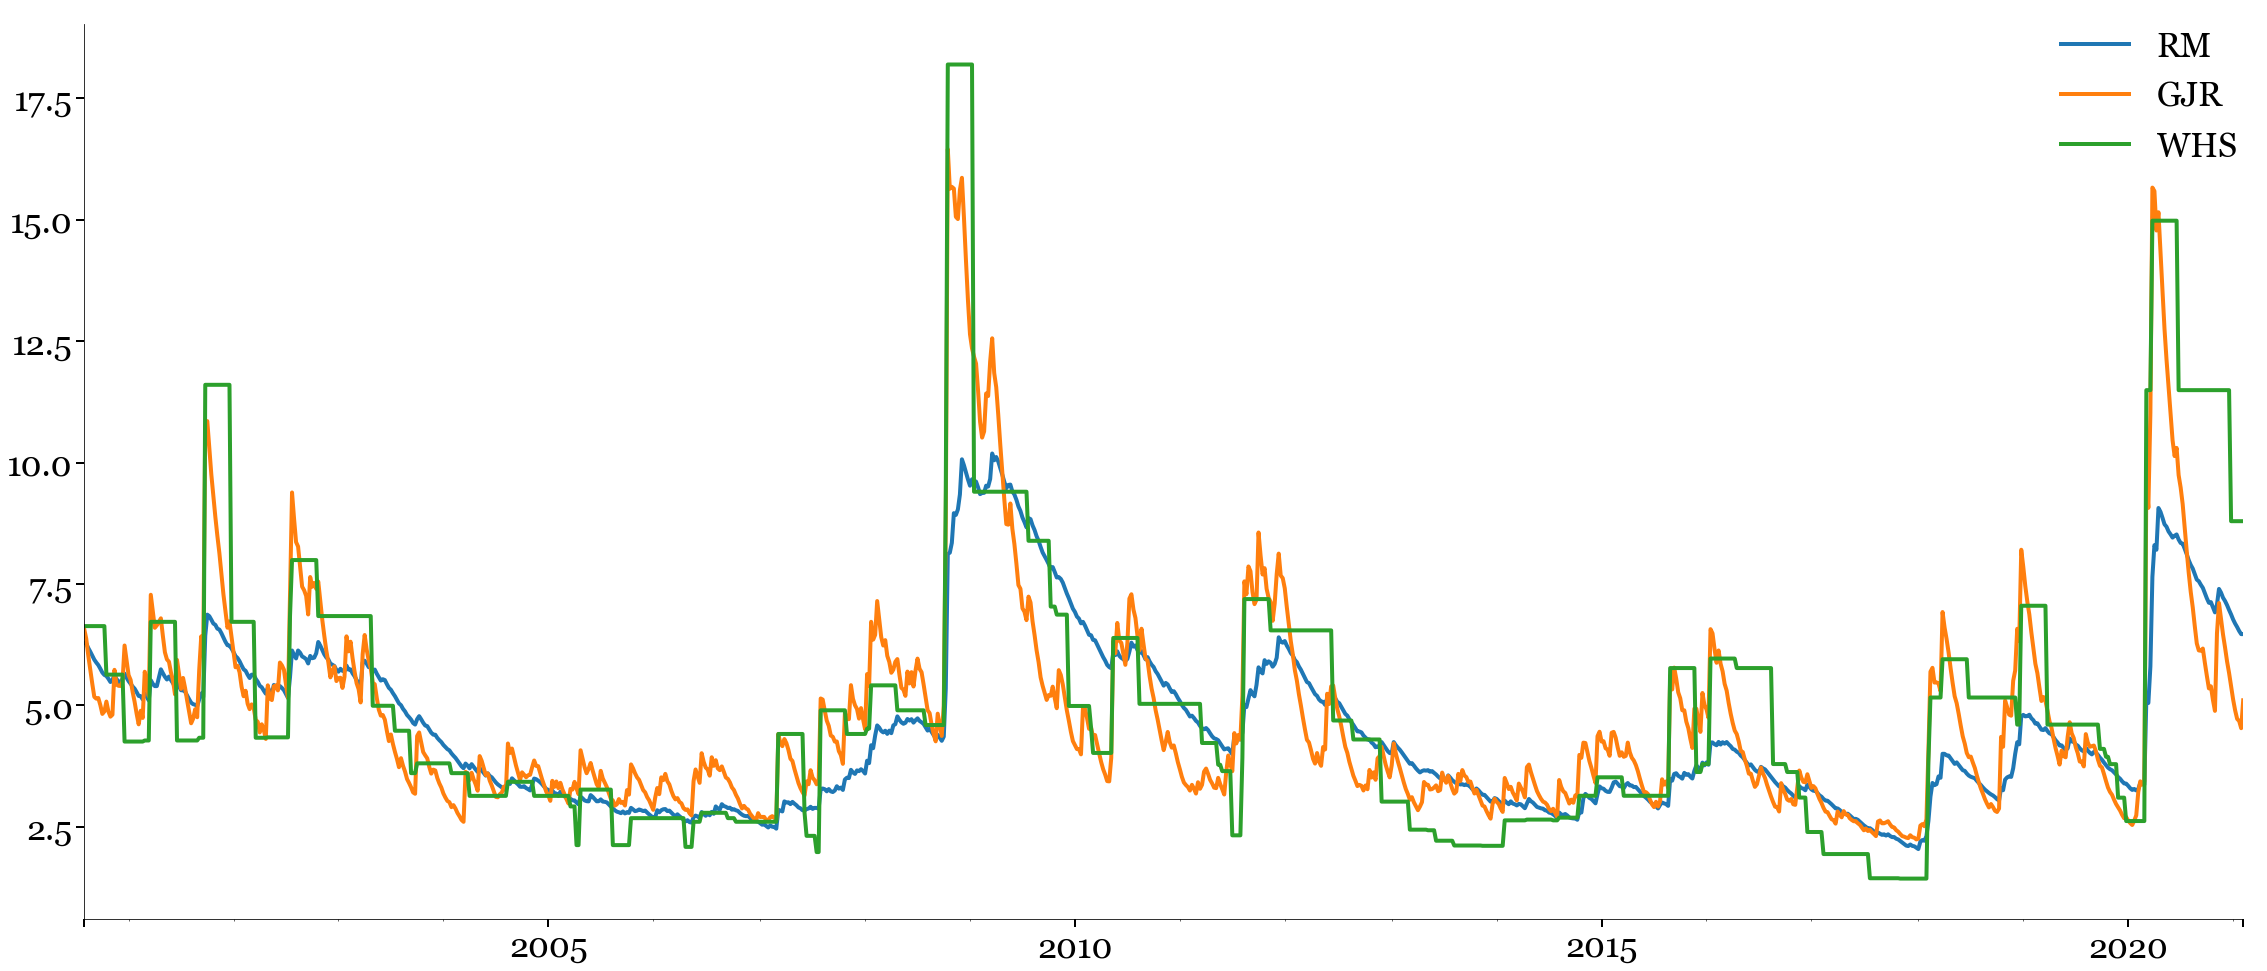

In [56]:
plot(weekly_vars)

# Evaluation: GMZ Regression

$$\text{HIT}_{t+h}=\gamma_{0}+\gamma_{1}VaR_{t+h|t}+\gamma_{2}\text{HIT}_{t}+\gamma_{3}\text{HIT}_{t-1}+\ldots+\gamma_{K}\text{HIT}_{t-K+1}+\eta_t$$


In [57]:
oos = sp500_weekly.loc[weekly_vars.index]
weekly_vars
var_exceed = oos.to_numpy()[:, None] < -weekly_vars
hits = var_exceed - alpha

In [58]:
from statsmodels.regression.linear_model import OLS


def gmz(hits, value_at_risks, col, lags=5):
    s = hits[col]
    v = value_at_risks[col]
    c = v.copy()
    c.loc[:] = 1
    x = pd.concat([c, v] + [s.shift(lag + 1) for lag in range(lags)], 1)
    common = pd.concat([s, x], 1).dropna()
    common.columns = ["HIT", "const", "VaR"] + [f"HIT.L{i}" for i in range(1, lags + 1)]
    res = OLS(common.iloc[:, 0], common.iloc[:, 1:]).fit(cov_type="HC0")
    return res

def joint_test(res):
    return pd.DataFrame({"stat":[res.fvalue],"P-value":[res.f_pvalue]},index=["Joint Test"])

# GMZ for Skew $t$ GJR

In [59]:
gjr_res = gmz(hits, weekly_vars, "GJR")
summary(gjr_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0105,0.010,1.020,0.308,-0.010,0.031
VaR,-0.0014,0.002,-0.797,0.426,-0.005,0.002
HIT.L1,0.0718,0.054,1.339,0.180,-0.033,0.177
HIT.L2,0.0009,0.034,0.027,0.978,-0.066,0.067
HIT.L3,0.0079,0.031,0.255,0.799,-0.053,0.069
HIT.L4,-0.0259,0.007,-3.568,0.000,-0.040,-0.012
HIT.L5,-0.0231,0.006,-4.015,0.000,-0.034,-0.012


In [60]:
joint_test(gjr_res)

,stat,P-value
Joint Test,4.823941,0.000072


# GMZ for RiskMetrics

In [61]:
rm_res = gmz(hits, weekly_vars, "RM")
summary(rm_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0457,0.014,3.156,0.002,0.017,0.074
VaR,-0.0083,0.002,-3.469,0.001,-0.013,-0.004
HIT.L1,0.0600,0.052,1.146,0.252,-0.043,0.163
HIT.L2,0.0851,0.056,1.511,0.131,-0.025,0.195
HIT.L3,0.0296,0.045,0.662,0.508,-0.058,0.117
HIT.L4,0.0897,0.056,1.604,0.109,-0.020,0.199
HIT.L5,-0.0265,0.027,-0.972,0.331,-0.080,0.027


In [62]:
joint_test(rm_res)

,stat,P-value
Joint Test,3.544817,0.001762


# GMZ for WHS

In [63]:
whs_res = gmz(hits, weekly_vars, "WHS")
summary(whs_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0323,0.011,2.892,0.004,0.010,0.054
VaR,-0.0049,0.001,-3.415,0.001,-0.008,-0.002
HIT.L1,0.0845,0.054,1.578,0.115,-0.020,0.189
HIT.L2,-0.0099,0.030,-0.329,0.742,-0.069,0.049
HIT.L3,0.0566,0.048,1.189,0.235,-0.037,0.150
HIT.L4,0.0239,0.040,0.592,0.554,-0.055,0.103
HIT.L5,-0.0297,0.008,-3.719,0.000,-0.045,-0.014


In [64]:
joint_test(whs_res)

,stat,P-value
Joint Test,4.33738,0.000247


# Evaluation: Unconditional Bernoulli Testing

* Likelihood of $T$ exceedences 

$$l(\alpha;\widetilde{\text{HIT}}_{t})=\sum_{t=1}^{T}{\widetilde{\text{HIT}}_{t}}\ln{\alpha}+\left(1-\widetilde{\text{HIT}}_{t}\right)\ln{1-\alpha} $$

* $\widetilde{\text{HIT}}$ is the indicator for a violation
* Easy to conduct a LR test  

$$LR=2(l(\hat{\alpha};\widetilde{\text{HIT}})-l(\alpha_{0};\widetilde{\text{HIT}}))\sim\chi_{1}^{2}$$

In [65]:
alpha_hat = var_exceed.mean(0)
lrs = {}
for col in var_exceed:
    null = stats.bernoulli(alpha).logpmf(var_exceed[col]).sum()
    alt = stats.bernoulli(alpha_hat[col]).logpmf(var_exceed[col]).sum()
    stat = 2 * (alt - null)
    lrs[col] = pd.Series({"LR": stat, "P_value": 1 - stats.chi2(1).cdf(stat)})

In [66]:
pd.DataFrame(lrs).T

,LR,P_value
RM,4.280032,0.038563
GJR,0.651270,0.419659
WHS,2.947361,0.086018


# Conditional Bernoulli Test
## Christoffersen's test

* Probability of a violation is independent of previous violation
* Leads to conditional Bernoulli distribution
* Has a close form expression
* Key inputs all depend on pairs $I_{[r_t<q_t]}$ and $I_{[r_{t-1}<q_{t-1}]}$ 

In [67]:
cond_lrs = {}
for col in var_exceed:
    lag = var_exceed[col].iloc[:-1].shift(1)
    curr = var_exceed[col].iloc[1:]
    n00 = ((1-lag)*(1-curr)).sum()
    n10 = ((1-lag)*(curr)).sum()
    n01 = ((lag)*(1-curr)).sum()
    n11 = ((lag)*(curr)).sum()
    p11=alpha
    p00=1-alpha
    p11_hat = n11/(n11+n01)
    p00_hat = n00/(n00+n10)
    null = n11*np.log(p11)+n01*np.log(1-p11)+n00*np.log(p00)+n10*np.log(1-p00)
    alt =  n11*np.log(p11_hat)+n01*np.log(1-p11_hat)+n00*np.log(p00_hat)+n10*np.log(1-p00_hat)
    stat = 2*(alt-null)
    pval = 1 - stats.chi2(2).cdf(stat)
    cond_lrs[col] = pd.Series({"LR": stat, "P_value": pval})

In [68]:
pd.DataFrame(cond_lrs).T

,LR,P_value
RM,8.109426,0.017340
GJR,4.000991,0.135268
WHS,7.424546,0.024422


# Evaluation: Using Logit to improve GMZ

* Same model as GMZ
* Exploit structure of exceedence to estimate using MLE
* Requires ensuring conditional probability is always $\in(0,1)$
  * Logit uses logistic function $ \Lambda\left(\cdot\right)$
  * Probit uses normal cdf  $ \Phi\left(\cdot\right)$

In [69]:
from statsmodels.api import Logit


def gmz_logit(hits, value_at_risks, col, lags=5):
    s = hits[col]
    v = value_at_risks[col]
    c = v.copy()
    c.loc[:] = 1
    x = pd.concat([c, v] + [s.shift(lag + 1) for lag in range(lags)], 1)
    common = pd.concat([s, x], 1).dropna()
    common.columns = ["HIT", "const", "VaR"] + [f"HIT.L{i}" for i in range(1, lags + 1)]
    res = Logit(common.iloc[:, 0], common.iloc[:, 1:]).fit(cov_type="HC0")
    return res

In [70]:
logit_res = gmz_logit(var_exceed.astype(float), weekly_vars, "GJR", lags=3)

Optimization terminated successfully.
         Current function value: 0.129413
         Iterations 8


In [71]:
summary(logit_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.2243,0.416,-7.751,0.000,-4.040,-2.409
VaR,-0.0814,0.080,-1.024,0.306,-0.237,0.074
HIT.L1,1.4990,0.647,2.315,0.021,0.230,2.768
HIT.L2,0.1203,1.110,0.108,0.914,-2.056,2.296
HIT.L3,0.2558,0.991,0.258,0.796,-1.686,2.198


In [72]:
def joint_logit_stat():
    exp_val = np.log(alpha / (1 - alpha))
    r = np.eye(5)
    q = np.zeros(5)
    q[0] = exp_val
    stat = logit_res.wald_test((r, q))
    return pd.DataFrame(
        {"stat": [float(stat.statistic)], "p-value": [stat.pvalue]}, index=["Joint Test"]
    )

In [73]:
joint_logit_stat()

,stat,p-value
Joint Test,9.267278,0.09886662583981386


# Next Week

* Expected Shortfall
* Density Forecasting
* Coherent Risk Measures